# SSD300

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


## Import statements

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches,patheffects

import torch
from torchvision import datasets,transforms,models
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader , Dataset
import torchvision.transforms.functional as FT

from PIL import Image
import xml.etree.ElementTree as ET


from pathlib import Path
import json
import os
import random
from tqdm import tqdm,trange
import time
from math import sqrt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"{torch.__version__} and {device}")

1.0.1.post2 and cuda


## Download the PASCAl VOC 2007 Dataset

In [0]:
!wget -q http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
!tar -xf VOCtrainval_06-Nov-2007.tar
dataPath=Path("VOCdevkit/VOC2007/")

In [6]:
!ls VOCdevkit/VOC2007

Annotations  ImageSets	JPEGImages  SegmentationClass  SegmentationObject


In [7]:
from os import walk
for (dirpath, dirnames, filenames) in walk("VOCdevkit/VOC2007"):
    print("Directory path: ", dirpath)
    print("Folder name: ", dirnames)
    print("File name: ", filenames)

Directory path:  VOCdevkit/VOC2007
Folder name:  ['SegmentationClass', 'ImageSets', 'SegmentationObject', 'Annotations', 'JPEGImages']
File name:  []
Directory path:  VOCdevkit/VOC2007/SegmentationClass
Folder name:  []
File name:  ['001420.png', '004558.png', '004392.png', '007417.png', '008645.png', '004423.png', '002669.png', '003349.png', '002376.png', '006704.png', '009422.png', '003188.png', '006066.png', '002234.png', '004190.png', '001397.png', '005790.png', '005130.png', '004722.png', '006944.png', '006866.png', '001834.png', '009252.png', '003711.png', '000121.png', '001872.png', '006400.png', '006560.png', '000768.png', '006699.png', '004644.png', '001901.png', '006761.png', '000250.png', '009295.png', '007524.png', '009597.png', '003506.png', '004866.png', '006698.png', '003957.png', '002565.png', '003786.png', '009655.png', '008430.png', '003587.png', '000515.png', '006171.png', '006549.png', '007480.png', '001724.png', '009605.png', '006660.png', '002099.png', '003118.png

## Transformations

### Horizontal Flip

In [0]:
def flip(image, boxes):
    """
    Flip image horizontally.

    :param image: image, a PIL Image
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :return: flipped image, updated bounding box coordinates
    """
    # Flip image
    new_image = FT.hflip(image)

    # Flip boxes
    new_boxes = boxes
    new_boxes[:, 0] = image.width - boxes[:, 0] - 1
    new_boxes[:, 2] = image.width - boxes[:, 2] - 1
    new_boxes = new_boxes[:, [2, 1, 0, 3]]

    return new_image, new_boxes

### Resize

In [0]:
def resize(image, boxes, dims=(300, 300), return_percent_coords=True):
  """
  Resize image. For the SSD300, resize to (300, 300).

  Since percent/fractional coordinates are calculated for the bounding boxes (w.r.t image dimensions) in this process,
  you may choose to retain them.

  :param image: image, a PIL Image
  :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
  :return: resized image, updated bounding box coordinates (or fractional coordinates, in which case they remain the same)
  """
  # Resize image
  new_image = FT.resize(image, dims)

  # Resize bounding boxes
  old_dims = torch.FloatTensor([image.width, image.height, image.width, image.height]).unsqueeze(0)
  new_boxes = boxes / old_dims  # percent coordinates

  if not return_percent_coords:
      new_dims = torch.FloatTensor([dims[1], dims[0], dims[1], dims[0]]).unsqueeze(0)
      new_boxes = new_boxes * new_dims

  return new_image, new_boxes


### Photometric Distortion

In [0]:
def photometric_distort(image):
  """
  Distort brightness, contrast, saturation, and hue, each with a 50% chance, in random order.

  :param image: image, a PIL Image
  :return: distorted image
  """
  new_image = image

  distortions = [FT.adjust_brightness,
                 FT.adjust_contrast,
                 FT.adjust_saturation,
                 FT.adjust_hue]

  random.shuffle(distortions)

  for d in distortions:
      if random.random() < 0.5:
          if d.__name__ is 'adjust_hue':
              # Caffe repo uses a 'hue_delta' of 18 - we divide by 255 because PyTorch needs a normalized value
              adjust_factor = random.uniform(-18 / 255., 18 / 255.)
          else:
              # Caffe repo uses 'lower' and 'upper' values of 0.5 and 1.5 for brightness, contrast, and saturation
              adjust_factor = random.uniform(0.5, 1.5)

          # Apply this distortion
          new_image = d(new_image, adjust_factor)

  return new_image

### Expand

In [0]:
def expand(image, boxes, filler):
    """
    Perform a zooming out operation by placing the image in a larger canvas of filler material.
    Helps to learn to detect smaller objects.
    :param image: image, a tensor of dimensions (3, original_h, original_w)
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :param filler: RBG values of the filler material, a list like [R, G, B]
    :return: expanded image, updated bounding box coordinates
    """
    # Calculate dimensions of proposed expanded (zoomed-out) image
    original_h = image.size(1)
    original_w = image.size(2)
    max_scale = 4
    scale = random.uniform(1, max_scale)
    new_h = int(scale * original_h)
    new_w = int(scale * original_w)

    # Create such an image with the filler
    filler = torch.FloatTensor(filler)  # (3)
    new_image = torch.ones((3, new_h, new_w), dtype=torch.float) * filler.unsqueeze(1).unsqueeze(1)  # (3, new_h, new_w)
    # Note - do not use expand() like new_image = filler.unsqueeze(1).unsqueeze(1).expand(3, new_h, new_w)
    # because all expanded values will share the same memory, so changing one pixel will change all

    # Place the original image at random coordinates in this new image (origin at top-left of image)
    left = random.randint(0, new_w - original_w)
    right = left + original_w
    top = random.randint(0, new_h - original_h)
    bottom = top + original_h
    new_image[:, top:bottom, left:right] = image

    # Adjust bounding boxes' coordinates accordingly
    new_boxes = boxes + torch.FloatTensor([left, top, left, top]).unsqueeze(
        0)  # (n_objects, 4), n_objects is the no. of objects in this image

    return new_image, new_boxes




### Random Crop

In [0]:
def random_crop(image, boxes, labels, difficulties):
    """
    Performs a random crop in the manner stated in the paper. Helps to learn to detect larger and partial objects.
    Note that some objects may be cut out entirely.
    Adapted from https://github.com/amdegroot/ssd.pytorch/blob/master/utils/augmentations.py
    :param image: image, a tensor of dimensions (3, original_h, original_w)
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :param labels: labels of objects, a tensor of dimensions (n_objects)
    :param difficulties: difficulties of detection of these objects, a tensor of dimensions (n_objects)
    :return: cropped image, updated bounding box coordinates, updated labels, updated difficulties
    """
    original_h = image.size(1)
    original_w = image.size(2)
    # Keep choosing a minimum overlap until a successful crop is made
    while True:
        # Randomly draw the value for minimum overlap
        min_overlap = random.choice([0., .1, .3, .5, .7, .9, None])  # 'None' refers to no cropping

        # If not cropping
        if min_overlap is None:
            return image, boxes, labels, difficulties

        # Try up to 50 times for this choice of minimum overlap
        # This isn't mentioned in the paper, of course, but 50 is chosen in paper authors' original Caffe repo
        max_trials = 50
        for _ in range(max_trials):
            # Crop dimensions must be in [0.3, 1] of original dimensions
            # Note - it's [0.1, 1] in the paper, but actually [0.3, 1] in the authors' repo
            min_scale = 0.3
            scale_h = random.uniform(min_scale, 1)
            scale_w = random.uniform(min_scale, 1)
            new_h = int(scale_h * original_h)
            new_w = int(scale_w * original_w)

            # Aspect ratio has to be in [0.5, 2]
            aspect_ratio = new_h / new_w
            if not 0.5 < aspect_ratio < 2:
                continue

            # Crop coordinates (origin at top-left of image)
            left = random.randint(0, original_w - new_w)
            right = left + new_w
            top = random.randint(0, original_h - new_h)
            bottom = top + new_h
            crop = torch.FloatTensor([left, top, right, bottom])  # (4)

            # Calculate Jaccard overlap between the crop and the bounding boxes
            overlap = find_jaccard_overlap(crop.unsqueeze(0),
                                           boxes)  # (1, n_objects), n_objects is the no. of objects in this image
            overlap = overlap.squeeze(0)  # (n_objects)

            # If not a single bounding box has a Jaccard overlap of greater than the minimum, try again
            if overlap.max().item() < min_overlap:
                continue

            # Crop image
            new_image = image[:, top:bottom, left:right]  # (3, new_h, new_w)

            # Find centers of original bounding boxes
            bb_centers = (boxes[:, :2] + boxes[:, 2:]) / 2.  # (n_objects, 2)

            # Find bounding boxes whose centers are in the crop
            centers_in_crop = (bb_centers[:, 0] > left) * (bb_centers[:, 0] < right) * (bb_centers[:, 1] > top) * (
                    bb_centers[:, 1] < bottom)  # (n_objects), a Torch uInt8/Byte tensor, can be used as a boolean index

            # If not a single bounding box has its center in the crop, try again
            if not centers_in_crop.any():
                continue

            # Discard bounding boxes that don't meet this criterion
            new_boxes = boxes[centers_in_crop, :]
            new_labels = labels[centers_in_crop]
            new_difficulties = difficulties[centers_in_crop]

            # Calculate bounding boxes' new coordinates in the crop
            new_boxes[:, :2] = torch.max(new_boxes[:, :2], crop[:2])  # crop[:2] is [left, top]
            new_boxes[:, :2] -= crop[:2]
            new_boxes[:, 2:] = torch.min(new_boxes[:, 2:], crop[2:])  # crop[2:] is [right, bottom]
            new_boxes[:, 2:] -= crop[:2]

            return new_image, new_boxes, new_labels, new_difficulties

### Cordinate conversion (Encoding-Decoding)

### Jacard Overlap(IoU)

Four helpful transformations  related with  bounding boxes coordinates:

In training data 
<br>
bounding box is represented using :
<br>
x_min , y_min , x_max , y_max

1. From boundary coordinates to centre size coordinates
<br>
Function- **xy_to_cxcy**
<br>
x_min,y_min,x_max,y_max -> c_x,c_y,w,h
2. Reverse of the above step 
<br>
Function - **cxcy_to_xy**
<br>
c_x , c_y , w , h -> x_min,y_min,x_max,y_max
<br>
3. Offset from bounding box (used in the loss function)
<br>
   Function - **cxcy_to_gcxgcy** 
   <br>
   1. g_c_x ,g_c_y -find the offset with respect to the prior box, and scale by the size of the prior box.
   2. g_w , g_h - scale by the size of the prior box, and convert to the log-space.
 <br>
4. Decoding the predicted offset to centre size coordinates
<br>
Function - **gcxgcy_to_cxcy**

## Utility Function 

In [0]:

def xy_to_cxcy(xy):
    """
    Convert bounding boxes from boundary coordinates (x_min, y_min, x_max, y_max) to center-size coordinates (c_x, c_y, w, h).

    :param xy: bounding boxes in boundary coordinates, a tensor of size (n_boxes, 4)
    :return: bounding boxes in center-size coordinates, a tensor of size (n_boxes, 4)
    """
    return torch.cat([(xy[:, 2:] + xy[:, :2]) / 2,  # c_x=(x_min+x_max)/2, similarly for c_y = (y_min+y_max)/2
                      xy[:, 2:] - xy[:, :2]], 1)  # w = x_max-x_min, similarly for h


def cxcy_to_xy(cxcy):
    """
    Convert bounding boxes from center-size coordinates (c_x, c_y, w, h) to boundary coordinates (x_min, y_min, x_max, y_max).

    :param cxcy: bounding boxes in center-size coordinates, a tensor of size (n_boxes, 4)
    :return: bounding boxes in boundary coordinates, a tensor of size (n_boxes, 4)
    """
    return torch.cat([cxcy[:, :2] - (cxcy[:, 2:] / 2),  # x_min, y_min
                      cxcy[:, :2] + (cxcy[:, 2:] / 2)], 1)  # x_max, y_max


def cxcy_to_gcxgcy(cxcy, priors_cxcy):
    """
    Encode bounding boxes (that are in center-size form) w.r.t. the corresponding prior boxes (that are in center-size form).

    For the center coordinates, find the offset with respect to the prior box, and scale by the size of the prior box.
    For the size coordinates, scale by the size of the prior box, and convert to the log-space.

    In the model, we are predicting bounding box coordinates in this encoded form.

    :param cxcy: bounding boxes in center-size coordinates, a tensor of size (n_priors, 4)
    :param priors_cxcy: prior boxes with respect to which the encoding must be performed, a tensor of size (n_priors, 4)
    :return: encoded bounding boxes, a tensor of size (n_priors, 4)
    """

    # The 10 and 5 below are referred to as 'variances' in the original Caffe repo, completely empirical
    # They are for some sort of numerical conditioning, for 'scaling the localization gradient'
    # See https://github.com/weiliu89/caffe/issues/155
    return torch.cat([(cxcy[:, :2] - priors_cxcy[:, :2]) / (priors_cxcy[:, 2:] / 10),  # g_c_x, g_c_y
                      torch.log(cxcy[:, 2:] / priors_cxcy[:, 2:]) * 5], 1)  # g_w, g_h


def gcxgcy_to_cxcy(gcxgcy, priors_cxcy):
    """
    Decode bounding box coordinates predicted by the model, since they are encoded in the form mentioned above.

    They are decoded into center-size coordinates.

    This is the inverse of the function above.

    :param gcxgcy: encoded bounding boxes, i.e. output of the model, a tensor of size (n_priors, 4)
    :param priors_cxcy: prior boxes with respect to which the encoding is defined, a tensor of size (n_priors, 4)
    :return: decoded bounding boxes in center-size form, a tensor of size (n_priors, 4)
    """

    return torch.cat([gcxgcy[:, :2] * priors_cxcy[:, 2:] / 10 + priors_cxcy[:, :2],  # c_x, c_y
                      torch.exp(gcxgcy[:, 2:] / 5) * priors_cxcy[:, 2:]], 1)  # w, h

Steps to follow:
1. Find Intersection
2. Find Union
3. Jaccard Overlap = Intersection / Union

In [0]:

def find_intersection(set_1, set_2):
    """
    Find the intersection of every box combination between two sets of boxes that are in boundary coordinates.

    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: intersection of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # PyTorch auto-broadcasts singleton dimensions
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)


def find_jaccard_overlap(set_1, set_2):
    """
    Find the Jaccard Overlap (IoU) of every box combination between two sets of boxes that are in boundary coordinates.

    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: Jaccard Overlap of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # Find intersections
    intersection = find_intersection(set_1, set_2)  # (n1, n2)

    # Find areas of each box in both sets
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)

    # Find the union
    # PyTorch auto-broadcasts singleton dimensions
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)

    return intersection / union  # (n1, n2)

## Dataset

In [0]:
class VOCDataset(Dataset):
  class_names = ('__background__','aeroplane', 'bicycle', 'bird', 'boat',
                 'bottle', 'bus', 'car', 'cat', 'chair',
                 'cow', 'diningtable', 'dog', 'horse',
                 'motorbike', 'person', 'pottedplant',
                 'sheep', 'sofa', 'train', 'tvmonitor')

  def __init__(self, data_dir, split,keep_difficult=True):
      """Dataset for VOC data.
      Args:
          data_dir: the root of the VOC2007 or VOC2012 dataset, the directory contains the following sub-directories:
              Annotations, ImageSets, JPEGImages, SegmentationClass, SegmentationObject.
          param keep_difficult: keep or discard objects that are considered difficult to detect?
      """
      self.mean = torch.tensor([0.485, 0.456, 0.406])
      self.std = torch.tensor([0.229, 0.224, 0.225])
      self.data_dir = data_dir      ##Hook the VOC data directory i.e datapath
      self.split = split            ## state whether it is a training or a validation or a test data
      self.keep_difficult = keep_difficult
      image_sets_file = self.data_dir/f"ImageSets/Main/{self.split}.txt"       ##hook to Imageset->Main>{train or valid or test}.txt file
      self.ids = VOCDataset._read_image_ids(image_sets_file)     ##call static method read_image_ids

      self.class_dict = {class_name: i for i, class_name in enumerate(self.class_names)}   ##store class name and their ids in dictionary

  def __getitem__(self, index):
      image_id = self.ids[index]   ##select a particular image  using an index say 000005
      boxes, labels,difficulties = self._get_annotation(image_id)  ## obtain boxes and labels by calling static method _get_annotation 
      image = self._read_image(image_id) ## get the jpg image 
      
       # Discard difficult objects, if desired
      if not self.keep_difficult:
          boxes = boxes[1 - difficulties]
          labels = labels[1 - difficulties]
          difficulties = difficulties[1 - difficulties]
      
      
      
      image, boxes, labels,difficulties = self.transform(image, boxes, labels ,difficulties, self.split)
      return image, boxes, labels,difficulties

  
  
  
  
  def get_image(self, index):
      image_id = self.ids[index]
      image = self._read_image(image_id)
      return image

  def get_annotation(self, index):
      image_id = self.ids[index]
      return self._get_annotation(image_id)

  def __len__(self):
      return len(self.ids)

  @staticmethod
  def _read_image_ids(image_sets_file):
    '''Go the the desired file->open it -> save the ids in the list and return the list'''
    ids = []
    with open(image_sets_file) as f:
      for line in f:
        ids.append(line.rstrip())
      return ids

  def _get_annotation(self, image_id):
    
    '''Parse xml file to get the object class and the coordinates of bounding boxes'''
    annotation_file = self.data_dir/f"Annotations/{image_id}.xml"
    objects = ET.parse(annotation_file).findall("object")
    boxes = []
    labels = []
    difficulties=[]
    for obj in objects:
        class_name = obj.find('name').text.lower().strip()
        bbox = obj.find('bndbox')
        difficult = obj.find('difficult').text
        # VOC dataset format follows Matlab, in which indexes start from 0
        x1 = float(bbox.find('xmin').text) - 1
        y1 = float(bbox.find('ymin').text) - 1
        x2 = float(bbox.find('xmax').text) - 1
        y2 = float(bbox.find('ymax').text) - 1
        boxes.append([x1, y1, x2, y2])
        labels.append(self.class_dict[class_name])
        difficulties.append(difficult)
        
    difficulties=torch.ByteTensor(np.array(difficulties).astype(np.float))
    return (np.array(boxes, dtype=np.float32),
            np.array(labels, dtype=np.int64),difficulties)

  def _read_image(self, image_id):
    image_file = self.data_dir/f"JPEGImages/{image_id}.jpg"
    image = Image.open(image_file).convert("RGB")
    return image

  def transform(self , image, boxes, labels ,difficulties, split):
    """
    Apply the transformations above.

    :param image: image, a PIL Image
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :param labels: labels of objects, a tensor of dimensions (n_objects)
    :return: transformed image, transformed bounding box coordinates, transformed labels
    """
    assert split in {'train', 'test' , "val"}
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Mean and standard deviation of ImageNet data that our base VGG from torchvision was trained on
    # see: https://pytorch.org/docs/stable/torchvision/models.html

    new_image = image
    new_boxes = torch.from_numpy(boxes)
    new_labels = torch.from_numpy(labels)
    new_difficulties = difficulties
    # Skip the following operations if validation/evaluation
    if split == 'train':
        # A series of photometric distortions in random order, each with 50% chance of occurrence, as in Caffe repo
        new_image = photometric_distort(new_image)

        # Convert PIL image to Torch tensor
        new_image = FT.to_tensor(new_image)
        
        # Expand image (zoom out) with a 50% chance - helpful for training detection of small objects
        # Fill surrounding space with the mean of ImageNet data that our base VGG was trained on
        if random.random() < 0.5:
            new_image, new_boxes = expand(new_image, new_boxes, filler=mean)

        # Randomly crop image (zoom in)
        new_image, new_boxes, new_labels, new_difficulties = random_crop(new_image, new_boxes, new_labels,
                                                                         new_difficulties)   
        
         # Convert Torch tensor to PIL image
        new_image = FT.to_pil_image(new_image)
        
        # Flip image with a 50% chance
        if random.random() < 0.5:
            new_image, new_boxes = flip(new_image, new_boxes)

    # Resize image to (300, 300) - this also converts point coordinates to fractional form
    new_image, new_boxes = resize(new_image, new_boxes, dims=(300, 300))

    # Convert PIL image to Torch tensor
    new_image = FT.to_tensor(new_image)

    # Normalize by mean and standard deviation of ImageNet data that our base VGG was trained on
    new_image = FT.normalize(new_image, mean=self.mean.numpy(), std=self.std.numpy())

    return new_image, new_boxes, new_labels ,new_difficulties

  def denormalize(self , image):
    image = image.clone().detach().to("cpu")
    if len(image.shape)==4 : image = image.squeeze(0)
    image = image.permute(1,2,0) 
    image = image.mul_(self.std).add_(self.mean) #denormalize
    image = torch.clamp(image,0,1)
    return image.numpy()
  
  
  def collate_fn(self, batch):
      
      
      """
      Since each image may have a different number of objects, we need a collate function (to be passed to the DataLoader).
      This describes how to combine these tensors of different sizes. We use lists.
      Note: this need not be defined in this Class, can be standalone.
      :param batch: an iterable of N sets from __getitem__()
      :return: a tensor of images, lists of varying-size tensors of bounding boxes, labels, and difficulties
      """

      images = list()
      boxes = list()
      labels = list()
      difficulties = list()

      for b in batch:
          images.append(b[0])
          boxes.append(b[1])
          labels.append(b[2])
          difficulties.append(b[3])

      images = torch.stack(images, dim=0)

      return images, boxes, labels,difficulties  # tensor (N, 3, 300, 300), 3 lists of N tensors each

In [14]:

    
'''Parse xml file to get the object class and the coordinates of bounding boxes'''
annotation_file = dataPath/f"Annotations/000005.xml"
objects = ET.parse(annotation_file).findall("object")
boxes = []
labels = []
difficulties =[]
for obj in objects:
    class_name = obj.find('name').text.lower().strip()
    bbox = obj.find('bndbox')
    difficulties.append(obj.find('difficult').text)
    print(np.array(difficulties))
    print(class_name)
    #difficulties=torch.ByteTensor(difficulties.astype(np.float))
    print(difficulties)
    # VOC dataset format follows Matlab, in which indexes start from 0
    x1 = float(bbox.find('xmin').text) - 1
    y1 = float(bbox.find('ymin').text) - 1
    x2 = float(bbox.find('xmax').text) - 1
    y2 = float(bbox.find('ymax').text) - 1
    boxes.append([x1, y1, x2, y2])
    #labels.append(self.class_dict[class_name])
difficulties=torch.ByteTensor(np.array(difficulties).astype(np.float))

['0']
chair
['0']
['0' '0']
chair
['0', '0']
['0' '0' '1']
chair
['0', '0', '1']
['0' '0' '1' '0']
chair
['0', '0', '1', '0']
['0' '0' '1' '0' '1']
chair
['0', '0', '1', '0', '1']


In [16]:
trainset  = VOCDataset(dataPath,split="train",keep_difficult=True)
valset = VOCDataset(dataPath,split="val",keep_difficult=True)
f"Number of training examples:{len(trainset)}, Number of valaidation examples:{len(valset)}"

'Number of training examples:2501, Number of valaidation examples:2510'



## Visualization of Augmentation and Original

In [0]:
def show_img(im, ax=None):
    ax.imshow(im)
    ax.grid()
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 3)

def draw_im(dataset , index):
    f, (ax, ax1) = plt.subplots(1, 2,figsize=(15,10))   
    ax.set_title("Augmented")
    ax1.set_title("original")

    image , boxes , labels,_ = dataset[index]
    image=dataset.denormalize(image)
    ax = show_img(image,ax)
    for box ,label in zip(boxes , labels):
        box = box * torch.FloatTensor([300]*4)
        draw_rect(ax,box )
        draw_text(ax, box[:2], dataset.class_names[label], sz=16)
    
    original = dataset.get_image(index)
    boxes , labels,difficulties = dataset.get_annotation(index)
    #print("Difficulty=",difficulties.item())
    ax1 = show_img(original,ax1)
    for box ,label in zip(boxes , labels):
      draw_rect(ax1,box )
      draw_text(ax1, box[:2], dataset.class_names[label], sz=16)

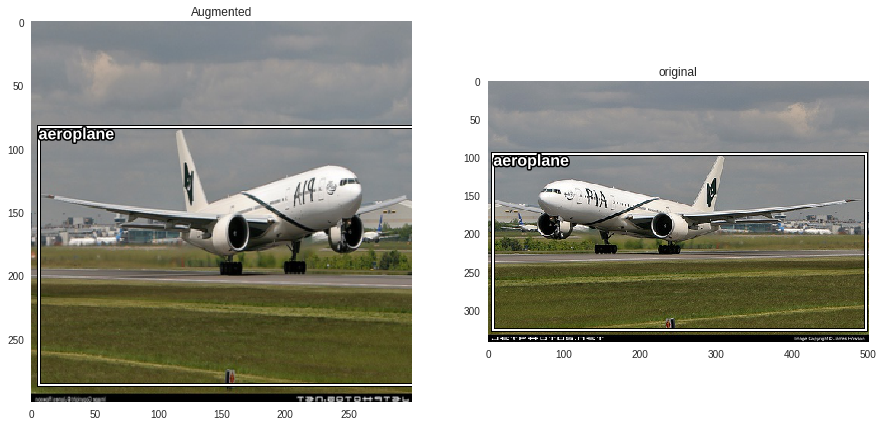

In [19]:
draw_im(trainset,59)

### Average Meter (Calculating running average)

In [0]:
class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

### Save Checkpoint

In [0]:
def save_checkpoint(epoch, epochs_since_improvement, model, optimizer, loss, best_loss, is_best):
    """
    Save model checkpoint.

    :param epoch: epoch number
    :param epochs_since_improvement: number of epochs since last improvement
    :param model: model
    :param optimizer: optimizer
    :param loss: validation loss in this epoch
    :param best_loss: best validation loss achieved so far (not necessarily in this checkpoint)
    :param is_best: is this checkpoint the best so far?
    """
    state = {'epoch': epoch,
             'epochs_since_improvement': epochs_since_improvement,
             'loss': loss,
             'best_loss': best_loss,
             'model': model.state_dict(),
             'optimizer': optimizer.state_dict()}
    filename = Path("/gdrive/My Drive/Meetup2019/Models/SSD/checkpoint_ssd300_d.pt")
    torch.save(state, filename)
    # If this checkpoint is the best so far, store a copy so it doesn't get overwritten by a worse checkpoint
    if is_best:
        torch.save(state,   Path("/gdrive/My Drive/Meetup2019/Models/SSD/BEST_checkpoint_ssd300_d.pt"))

### Decimate

In [0]:
def decimate(tensor, m):
    """
    Decimate a tensor by a factor 'm', i.e. downsample by keeping every 'm'th value.

    This is used when we convert FC layers to equivalent Convolutional layers, BUT of a smaller size.

    :param tensor: tensor to be decimated
    :param m: list of decimation factors for each dimension of the tensor; None if not to be decimated along a dimension
    :return: decimated tensor
    """
    assert tensor.dim() == len(m)
    for d in range(tensor.dim()):
        if m[d] is not None:
            tensor = tensor.index_select(dim=d,
                                         index=torch.arange(start=0, end=tensor.size(d), step=m[d]).long())

    return tensor

  
def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.

    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

## Model Architecture

Modification in Vgg Network:

1. ** Input Image**  
300 x300  instead of 224 x 224
<br>
2. ** 3rd Layer ** 
Ceil Mode
Significant if the dimensions of the preceding feature map are odd and not even.In this case we get the input as 75 x75 which is halved to to 38, 38 instead of an inconvenient 37, 37.
<br>
3. **Max Pooling** 
5th pooling layer -
From a 2, 2 kernel and 2 stride to a 3, 3 kernel and 1 stride. The effect this has is it no longer halves the dimensions of the feature map from the preceding convolutional layer.
<br>
4. ** Linear Layer **
We will toss fc8  which is the classification layer.
 Rework(decimate) fc6 and fc7 into convolutional layers conv6 and conv7. 
5. **Auxiliary Connection**
Stacking some more convolutional layers on top of our base network
6. Multiple Output Feature Map used for Detection:  
  1. Conv4_3   - 38 x 38 x 512
  2. Conv_7     - 19 x 19 x 1024
  3. Conv_8_2 - 10 x 10 x 512
  4. Conv_9_2 -  5 x 5 x 256
  5. Conv_10_2- 3 x 3 x 256
  6. Conv_11_2- 1 x 1 x 256
7. **Prediction Convolution**
Two Covolution layer for each feature map for calss prediction  and localization prediction.

### VGG-16 Base

In [0]:
class VGGBase(nn.Module):
    """
    VGG base convolutions to produce lower-level feature maps.
    """

    def __init__(self):
        super(VGGBase, self).__init__()

        # Standard convolutional layers in VGG16
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)  # stride = 1, by default
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)  # ceiling (not floor) here for even dims

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)  # retains size because stride is 1 (and padding)

        # Replacements for FC6 and FC7 in VGG16
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)  # atrous convolution

        self.conv7 = nn.Conv2d(1024, 1024, kernel_size=1)

    def forward(self, image):
        """
        Forward propagation.

        :param image: images, a tensor of dimensions (N, 3, 300, 300)
        :return: lower-level feature maps conv4_3 and conv7
        """
        out = F.relu(self.conv1_1(image))  # (N, 64, 300, 300)
        out = F.relu(self.conv1_2(out))  # (N, 64, 300, 300)
        out = self.pool1(out)  # (N, 64, 150, 150)

        out = F.relu(self.conv2_1(out))  # (N, 128, 150, 150)
        out = F.relu(self.conv2_2(out))  # (N, 128, 150, 150)
        out = self.pool2(out)  # (N, 128, 75, 75)

        out = F.relu(self.conv3_1(out))  # (N, 256, 75, 75)
        out = F.relu(self.conv3_2(out))  # (N, 256, 75, 75)
        out = F.relu(self.conv3_3(out))  # (N, 256, 75, 75)
        out = self.pool3(out)  # (N, 256, 38, 38), it would have been 37 if not for ceil_mode = True

        out = F.relu(self.conv4_1(out))  # (N, 512, 38, 38)
        out = F.relu(self.conv4_2(out))  # (N, 512, 38, 38)
        out = F.relu(self.conv4_3(out))  # (N, 512, 38, 38)
        conv4_3_feats = out  # (N, 512, 38, 38)
        out = self.pool4(out)  # (N, 512, 19, 19)

        out = F.relu(self.conv5_1(out))  # (N, 512, 19, 19)
        out = F.relu(self.conv5_2(out))  # (N, 512, 19, 19)
        out = F.relu(self.conv5_3(out))  # (N, 512, 19, 19)
        out = self.pool5(out)  # (N, 512, 19, 19), pool5 does not reduce dimensions

        out = F.relu(self.conv6(out))  # (N, 1024, 19, 19)

        conv7_feats = F.relu(self.conv7(out))  # (N, 1024, 19, 19)

        # Lower-level feature maps
        return conv4_3_feats, conv7_feats

### AuxiliaryConvolutions

Stack some more convolutional layers on top of our base network.These convolutions provide additional feature maps, each progressively smaller than the last.

Conv8_1 ,  Conv8_2 
<br>
Conv9_1 ,  Conv9_2
<br>
Conv10_1 ,Conv_10_2 
<br>
Conv11_1 ,Conv_11_2
<br>
Feature Map from Conv_8_2 , Conv9_2 , Conv_10_2 , Conv_11_2 will be used for Detection

In [0]:
class AuxiliaryConvolutions(nn.Module):
    """
    Additional convolutions to produce higher-level feature maps.
    """

    def __init__(self):
        super(AuxiliaryConvolutions, self).__init__()

        # Auxiliary/additional convolutions on top of the VGG base
        self.conv8_1 = nn.Conv2d(1024, 256, kernel_size=1, padding=0)  # stride = 1, by default
        self.conv8_1bn = nn.BatchNorm2d(256)
        self.conv8_1d = nn.Dropout(0.2)
        self.conv8_2 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)  # dim. reduction because stride > 1
        

        self.conv9_1 = nn.Conv2d(512, 128, kernel_size=1, padding=0)
        self.conv9_1bn = nn.BatchNorm2d(128)
        self.conv9_1d = nn.Dropout(0.2)
        self.conv9_2 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)  # dim. reduction because stride > 1

        self.conv10_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv10_1bn = nn.BatchNorm2d(128)
        self.conv10_1d = nn.Dropout(0.2)
        self.conv10_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)  # dim. reduction because padding = 0

        self.conv11_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv11_1bn = nn.BatchNorm2d(128)
        self.conv11_1d = nn.Dropout(0.2)
        self.conv11_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)  # dim. reduction because padding = 0

    def forward(self, conv7_feats):
        """
        Forward propagation.

        :param conv7_feats: lower-level conv7 feature map, a tensor of dimensions (N, 1024, 19, 19)
        :return: higher-level feature maps conv8_2, conv9_2, conv10_2, and conv11_2
        """
        out = F.relu(self.conv8_1(conv7_feats))  # (N, 256, 19, 19)
        out=  self.conv8_1d(self.conv8_1bn(out))
        out = F.relu(self.conv8_2(out))  # (N, 512, 10, 10)
        conv8_2_feats = out  # (N, 512, 10, 10)

        out = F.relu(self.conv9_1(out))  # (N, 128, 10, 10)
        out=  self.conv9_1d(self.conv9_1bn(out))
        out = F.relu(self.conv9_2(out))  # (N, 256, 5, 5)
        conv9_2_feats = out  # (N, 256, 5, 5)

        out = F.relu(self.conv10_1(out))  # (N, 128, 5, 5)
        out=  self.conv10_1d(self.conv10_1bn(out))
        out = F.relu(self.conv10_2(out))  # (N, 256, 3, 3)
        conv10_2_feats = out  # (N, 256, 3, 3)

        out = F.relu(self.conv11_1(out))  # (N, 128, 3, 3)
        out=  self.conv11_1d(self.conv11_1bn(out))
        conv11_2_feats = F.relu(self.conv11_2(out))  # (N, 256, 1, 1)

        # Higher-level feature maps
        return conv8_2_feats, conv9_2_feats, conv10_2_feats,conv11_2_feats

### Prediction Convolution

For each prior at each location on each feature map, we want to predict –
1. the offsets (g_c_x, g_c_y, g_w, g_h) for a bounding box.
2. a set of n_classes scores for the bounding box, where n_classes represents the total number of object types (including a background class).

What we do:
<br>
We need two convolutional layers for each feature map 
1. A ** localization prediction convolutional layer** with a 3, 3 kernel evaluating at each location (i.e. with padding and stride of 1) with 4 filters for each prior present at the location.

The 4 filters for a prior calculate the four encoded offsets (g_c_x, g_c_y, g_w, g_h) for the bounding box predicted from that prior.

2. A **class prediction convolutional layer** with a 3, 3 kernel evaluating at each location (i.e. with padding and stride of 1) with n_classes filters for each prior present at the location.

The n_classes filters for a prior calculate a set of n_classes scores for that prior.


Let us take one output feature map and understand :
 
Considering Conv_9_2 output feature map of size 5 x 5 x256

Step1:
1. For localization:
    1. Convolution:
    5 x 5 x 256 ->  3 x 3 x 24  [6(Anchor boxes) x 4(Coordinates)]
    2. Output of size = 5 x 5 x 24 
    3. Resize to 150(5x5x6 ) x 4
   
2. For class prediction 
     1.Convolution:
    5 x 5 x 256 ->  3 x 3 x  126  [ 6 (Anchor Boxes)x 21 [20(Class Labels) +1(Background)]]
    2. Output of size = 5 x 5 x 126 
    3. Resize to 150(5x5x6 ) x 21
    
    
 Similarly we do for all output feature maps and stack the results together .Thus the  Output from the Predicted Convolution module is the following:
 1. locs = 8732 x 4
 2. class scores = 8732 x 21

In [0]:
class PredictionConvolutions(nn.Module):
    """
    Convolutions to predict class scores and bounding boxes using lower and higher-level feature maps.

    The bounding boxes (locations) are predicted as encoded offsets w.r.t each of the 8732 prior (default) boxes.

    The class scores represent the scores of each object class in each of the 8732 bounding boxes located.
    A high score for 'background' = no object.
    """

    def __init__(self, n_classes):
        """
        :param n_classes: number of different types of objects
        """
        super(PredictionConvolutions, self).__init__()

        self.n_classes = n_classes

        # Number of prior-boxes we are considering per position in each feature map
        n_boxes = {'conv4_3': 4,
                   'conv7': 6,
                   'conv8_2': 6,
                   'conv9_2': 6,
                   'conv10_2': 4,
                   'conv11_2': 4}
        # 4 prior-boxes implies we use 4 different aspect ratios, etc.

        # Localization prediction convolutions (predict offsets w.r.t prior-boxes)
        # We multiply by 4 as for each anchor box we need 4 offset values
        self.loc_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * 4, kernel_size=3, padding=1)
        self.loc_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * 4, kernel_size=3, padding=1)
        self.loc_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * 4, kernel_size=3, padding=1)

        # Class prediction convolutions (predict classes in localization boxes)
        self.cl_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * n_classes, kernel_size=3, padding=1)

    def forward(self, conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats):
        """
        Forward propagation.

        :param conv4_3_feats: conv4_3 feature map, a tensor of dimensions (N, 512, 38, 38)
        :param conv7_feats: conv7 feature map, a tensor of dimensions (N, 1024, 19, 19)
        :param conv8_2_feats: conv8_2 feature map, a tensor of dimensions (N, 512, 10, 10)
        :param conv9_2_feats: conv9_2 feature map, a tensor of dimensions (N, 256, 5, 5)
        :param conv10_2_feats: conv10_2 feature map, a tensor of dimensions (N, 256, 3, 3)
        :param conv11_2_feats: conv11_2 feature map, a tensor of dimensions (N, 256, 1, 1)
        :return: 8732 locations and class scores (i.e. w.r.t each prior box) for each image
        """
        batch_size = conv4_3_feats.size(0)

        # Predict localization boxes' bounds (as offsets w.r.t prior-boxes)
        l_conv4_3 = self.loc_conv4_3(conv4_3_feats)  # (N, 16, 38, 38)
        l_conv4_3 = l_conv4_3.permute(0, 2, 3,
                                      1).contiguous()  # (N, 38, 38, 16), to match prior-box order (after .view())
        # (.contiguous() ensures it is stored in a contiguous chunk of memory, needed for .view() below)
        l_conv4_3 = l_conv4_3.view(batch_size, -1, 4)  # (N, 5776, 4), there are a total 5776 boxes on this feature map

        l_conv7 = self.loc_conv7(conv7_feats)  # (N, 24, 19, 19)
        l_conv7 = l_conv7.permute(0, 2, 3, 1).contiguous()  # (N, 19, 19, 24)
        l_conv7 = l_conv7.view(batch_size, -1, 4)  # (N, 2166, 4), there are a total 2116 boxes on this feature map

        l_conv8_2 = self.loc_conv8_2(conv8_2_feats)  # (N, 24, 10, 10)
        l_conv8_2 = l_conv8_2.permute(0, 2, 3, 1).contiguous()  # (N, 10, 10, 24)
        l_conv8_2 = l_conv8_2.view(batch_size, -1, 4)  # (N, 600, 4)

        l_conv9_2 = self.loc_conv9_2(conv9_2_feats)  # (N, 24, 5, 5)
        l_conv9_2 = l_conv9_2.permute(0, 2, 3, 1).contiguous()  # (N, 5, 5, 24)
        l_conv9_2 = l_conv9_2.view(batch_size, -1, 4)  # (N, 150, 4)

        l_conv10_2 = self.loc_conv10_2(conv10_2_feats)  # (N, 16, 3, 3)
        l_conv10_2 = l_conv10_2.permute(0, 2, 3, 1).contiguous()  # (N, 3, 3, 16)
        l_conv10_2 = l_conv10_2.view(batch_size, -1, 4)  # (N, 36, 4)

        l_conv11_2 = self.loc_conv11_2(conv11_2_feats)  # (N, 16, 1, 1)
        l_conv11_2 = l_conv11_2.permute(0, 2, 3, 1).contiguous()  # (N, 1, 1, 16)
        l_conv11_2 = l_conv11_2.view(batch_size, -1, 4)  # (N, 4, 4)

        # Predict classes in localization boxes
        c_conv4_3 = self.cl_conv4_3(conv4_3_feats)  # (N, 4 * n_classes, 38, 38)
        c_conv4_3 = c_conv4_3.permute(0, 2, 3,
                                      1).contiguous()  # (N, 38, 38, 4 * n_classes), to match prior-box order (after .view())
        c_conv4_3 = c_conv4_3.view(batch_size, -1,
                                   self.n_classes)  # (N, 5776, n_classes), there are a total 5776 boxes on this feature map

        c_conv7 = self.cl_conv7(conv7_feats)  # (N, 6 * n_classes, 19, 19)
        c_conv7 = c_conv7.permute(0, 2, 3, 1).contiguous()  # (N, 19, 19, 6 * n_classes)
        c_conv7 = c_conv7.view(batch_size, -1,
                               self.n_classes)  # (N, 2166, n_classes), there are a total 2116 boxes on this feature map

        c_conv8_2 = self.cl_conv8_2(conv8_2_feats)  # (N, 6 * n_classes, 10, 10)
        c_conv8_2 = c_conv8_2.permute(0, 2, 3, 1).contiguous()  # (N, 10, 10, 6 * n_classes)
        c_conv8_2 = c_conv8_2.view(batch_size, -1, self.n_classes)  # (N, 600, n_classes)

        c_conv9_2 = self.cl_conv9_2(conv9_2_feats)  # (N, 6 * n_classes, 5, 5)
        c_conv9_2 = c_conv9_2.permute(0, 2, 3, 1).contiguous()  # (N, 5, 5, 6 * n_classes)
        c_conv9_2 = c_conv9_2.view(batch_size, -1, self.n_classes)  # (N, 150, n_classes)

        c_conv10_2 = self.cl_conv10_2(conv10_2_feats)  # (N, 4 * n_classes, 3, 3)
        c_conv10_2 = c_conv10_2.permute(0, 2, 3, 1).contiguous()  # (N, 3, 3, 4 * n_classes)
        c_conv10_2 = c_conv10_2.view(batch_size, -1, self.n_classes)  # (N, 36, n_classes)

        c_conv11_2 = self.cl_conv11_2(conv11_2_feats)  # (N, 4 * n_classes, 1, 1)
        c_conv11_2 = c_conv11_2.permute(0, 2, 3, 1).contiguous()  # (N, 1, 1, 4 * n_classes)
        c_conv11_2 = c_conv11_2.view(batch_size, -1, self.n_classes)  # (N, 4, n_classes)

        # A total of 8732 boxes
        #There will be 8732 channels corresponsing to 8732 boxes having 4 values 
        # Concatenate in this specific order (i.e. must match the order of the prior-boxes)
        locs = torch.cat([l_conv4_3, l_conv7, l_conv8_2, l_conv9_2, l_conv10_2, l_conv11_2], dim=1)  # (N, 8732, 4)
        classes_scores = torch.cat([c_conv4_3, c_conv7, c_conv8_2, c_conv9_2, c_conv10_2, c_conv11_2],
                                   dim=1)  # (N, 8732, n_classes)

        return locs, classes_scores

## SSD 300

In this module we will be assembling all the individual modules to make a SSD network.

Things to do :
1. Make biases of layers of Auxiliary Convolution  and Predicted Convolution to 0.
2. Use Pretrained weights of vgg16 to fit first 5 Conv layers of custom vgg network.
3. Use Decimate (subsample technique) to fit linear layer weights  of vgg-16 to conv layer 6 and 7 to our custom  vgg network.
*Refer SSD helper.ipynb*
4. Rescale the Conv_4_2 output feature map due to large size
5. Create prior boxes
    *Refer SSD Helper.ipynb*


Prior Boxes

Things to remember:
 1. $Width(w) * Height(h)$ = $Scale^2(s)$   
 2. $Width(w) / Height(h)$     = $Aspect Ratio(a)$
 
 Given a and s :
 1. $w = s * \sqrt a$  
 2. $h = s / \sqrt a $
 

In [0]:
class SSD300(nn.Module):
    """
    The SSD300 network - encapsulates the base VGG network, auxiliary, and prediction convolutions.
    """

    def __init__(self, n_classes):
        super(SSD300, self).__init__()

        self.n_classes = n_classes

        self.base = VGGBase()
        self.aux_convs = AuxiliaryConvolutions()
        self.pred_convs = PredictionConvolutions(n_classes)

        # Since lower level features (conv4_3_feats) have considerably larger scales, we take the L2 norm and rescale
        # Rescale factor is initially set at 20, but is learned for each channel during back-prop
        self.rescale_factors = nn.Parameter(torch.FloatTensor(1, 512, 1, 1))  # there are 512 channels in conv4_3_feats
        nn.init.constant_(self.rescale_factors, 20)

        # Prior boxes
        self.priors_cxcy = self.create_prior_boxes()
        self.init_conv2d()
    def init_conv2d(self):
      """
      Initialize convolution parameters.

      Note that we only do this for the auxiliary and prediction convolutions. The VGG base is a pre-trained model.
      """
      for c in self.aux_convs.children():
          if isinstance(c, nn.Conv2d):
              nn.init.constant_(c.bias, 0.)
      for c in self.pred_convs.children():
          if isinstance(c, nn.Conv2d):
              nn.init.constant_(c.bias, 0.)
              
    def load_pretrained_base(self):
        """
        As in the paper, we use a VGG-16 pretrained on the ImageNet task as the base network.
        There's one available in PyTorch, see https://pytorch.org/docs/stable/torchvision/models.html#torchvision.models.vgg16
        We copy these parameters into our network. It's straightforward for conv1 to conv5.
        However, the original VGG-16 does not contain the conv6 and con7 layers.
        Therefore, we convert fc6 and fc7 into convolutional layers, and subsample by decimation. See 'decimate' in utils.py.
        """
        # Current state of VGG base
        base_state_dict = self.base.state_dict()
        base_param_names = list(base_state_dict.keys())

        # Pretrained VGG base
        pretrained_base_state_dict = models.vgg16(pretrained=True).state_dict()
        pretrained_base_param_names = list(pretrained_base_state_dict.keys())

        # Transfer conv. parameters from pretrained model to current model
        for i, param in enumerate(base_param_names[:-4]):  # excluding conv6 and conv7 parameters
            base_state_dict[param] = pretrained_base_state_dict[pretrained_base_param_names[i]]

        # Convert fc6, fc7 to convolutional layers, and subsample (by decimation) to sizes of conv6 and conv7
        # fc6
        conv_fc6_weight = pretrained_base_state_dict['classifier.0.weight'].view(4096, 512, 7, 7)  # (4096, 512, 7, 7)
        conv_fc6_bias = pretrained_base_state_dict['classifier.0.bias']  # (4096)
        base_state_dict['conv6.weight'] = decimate(conv_fc6_weight, m=[4, None, 3, 3])  # (1024, 512, 3, 3)
        base_state_dict['conv6.bias'] = decimate(conv_fc6_bias, m=[4])  # (1024)
        # fc7
        conv_fc7_weight = pretrained_base_state_dict['classifier.3.weight'].view(4096, 4096, 1, 1)  # (4096, 4096, 1, 1)
        conv_fc7_bias = pretrained_base_state_dict['classifier.3.bias']  # (4096)
        base_state_dict['conv7.weight'] = decimate(conv_fc7_weight, m=[4, 4, None, None])  # (1024, 1024, 1, 1)
        base_state_dict['conv7.bias'] = decimate(conv_fc7_bias, m=[4])  # (1024)

        # Note: an FC layer of size (K) operating on a flattened version (C*H*W) of a 2D image of size (C, H, W)...
        # ...is equivalent to a convolutional layer with kernel size (H, W), input channels C, output channels K...
        # ...operating on the 2D image of size (C, H, W) without padding

        self.base.load_state_dict(base_state_dict)
        
        for layers in [*self.base.modules()][1:6]:
          for param in layers.parameters():
            param.requires_grad_(False)              
        print("Freeze first 4 layers")

        print("\nLoaded base model.\n")
    def forward(self, image):
        """
        Forward propagation.

        :param image: images, a tensor of dimensions (N, 3, 300, 300)
        :return: 8732 locations and class scores (i.e. w.r.t each prior box) for each image
        """
        # Run VGG base network convolutions (lower level feature map generators)
        conv4_3_feats, conv7_feats = self.base(image)  # (N, 512, 38, 38), (N, 1024, 19, 19)

        # Rescale conv4_3 after L2 norm
        norm = conv4_3_feats.pow(2).sum(dim=1, keepdim=True).sqrt()  # (N, 1, 38, 38)
        conv4_3_feats = conv4_3_feats / norm  # (N, 512, 38, 38)
        conv4_3_feats = conv4_3_feats * self.rescale_factors  # (N, 512, 38, 38)
        # (PyTorch autobroadcasts singleton dimensions during arithmetic)

        # Run auxiliary convolutions (higher level feature map generators)
        conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats =self.aux_convs(conv7_feats)  # (N, 512, 10, 10),  (N, 256, 5, 5), (N, 256, 3, 3), (N, 256, 1, 1)

        # Run prediction convolutions (predict offsets w.r.t prior-boxes and classes in each resulting localization box)
        locs, classes_scores = self.pred_convs(conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats,conv11_2_feats)  # (N, 8732, 4), (N, 8732, n_classes)

        return locs, classes_scores

    def create_prior_boxes(self):
        """
        Create the 8732 prior (default) boxes for the SSD300, as defined in the paper.

        :return: prior boxes in center-size coordinates, a tensor of dimensions (8732, 4)
        """
        fmap_dims = {'conv4_3': 38,
                     'conv7': 19,
                     'conv8_2': 10,
                     'conv9_2': 5,
                     'conv10_2': 3,
                     'conv11_2': 1}

        obj_scales = {'conv4_3': 0.1,
                      'conv7': 0.2,
                      'conv8_2': 0.375,
                      'conv9_2': 0.55,
                      'conv10_2': 0.725,
                      'conv11_2': 0.9}

        aspect_ratios = {'conv4_3': [1., 2., 0.5],
                         'conv7': [1., 2., 3., 0.5, .333],
                         'conv8_2': [1., 2., 3., 0.5, .333],
                         'conv9_2': [1., 2., 3., 0.5, .333],
                         'conv10_2': [1., 2., 0.5],
                         'conv11_2': [1., 2., 0.5]}

        fmaps = list(fmap_dims.keys())

        prior_boxes = []

        for k, fmap in enumerate(fmaps):
            for i in range(fmap_dims[fmap]):
                for j in range(fmap_dims[fmap]):
                    cx = (j + 0.5) / fmap_dims[fmap]
                    cy = (i + 0.5) / fmap_dims[fmap]

                    for ratio in aspect_ratios[fmap]:
                        prior_boxes.append([cx, cy, obj_scales[fmap] * sqrt(ratio), obj_scales[fmap] / sqrt(ratio)])

                        # For an aspect ratio of 1, use an additional prior whose scale is the geometric mean of the
                        # scale of the current feature map and the scale of the next feature map
                        if ratio == 1.:
                            try:
                                additional_scale = sqrt(obj_scales[fmap] * obj_scales[fmaps[k + 1]])
                            # For the last feature map, there is no "next" feature map
                            except IndexError:
                                additional_scale = 1.
                            prior_boxes.append([cx, cy, additional_scale, additional_scale])

        prior_boxes = torch.FloatTensor(prior_boxes).to(device)  # (8732, 4)
        prior_boxes.clamp_(0, 1)  # (8732, 4)

        return prior_boxes
      
      
    def detect_objects(self, predicted_locs, predicted_scores, min_score, max_overlap, top_k):
      """
      Decipher the 8732 locations and class scores (output of ths SSD300) to detect objects.
      For each class, perform Non-Maximum Suppression (NMS) on boxes that are above a minimum threshold.
      :param predicted_locs: predicted locations/boxes w.r.t the 8732 prior boxes, a tensor of dimensions (N, 8732, 4)
      :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 8732, n_classes)
      :param min_score: minimum threshold for a box to be considered a match for a certain class
      :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via NMS
      :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
      :return: detections (boxes, labels, and scores), lists of length batch_size
      """
      batch_size = predicted_locs.size(0)
      n_priors = self.priors_cxcy.size(0)
      predicted_scores = F.softmax(predicted_scores, dim=2)  # (N, 8732, n_classes)

      # Lists to store final predicted boxes, labels, and scores for all images
      all_images_boxes = list()
      all_images_labels = list()
      all_images_scores = list()

      assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

      for i in range(batch_size):
          # Decode object coordinates from the form we regressed predicted boxes to
          decoded_locs = cxcy_to_xy(
              gcxgcy_to_cxcy(predicted_locs[i], self.priors_cxcy))  # (8732, 4), these are fractional pt. coordinates

          # Lists to store boxes and scores for this image
          image_boxes = list()
          image_labels = list()
          image_scores = list()

          max_scores, best_label = predicted_scores[i].max(dim=1)  # (8732)

          # Check for each class
          for c in range(1, self.n_classes):
              # Keep only predicted boxes and scores where scores for this class are above the minimum score
              class_scores = predicted_scores[i][:, c]  # (8732)
              score_above_min_score = class_scores > min_score  # torch.uint8 (byte) tensor, for indexing
              n_above_min_score = score_above_min_score.sum().item()
              if n_above_min_score == 0:
                  continue
              class_scores = class_scores[score_above_min_score]  # (n_qualified), n_min_score <= 8732
              class_decoded_locs = decoded_locs[score_above_min_score]  # (n_qualified, 4)

              # Sort predicted boxes and scores by scores
              class_scores, sort_ind = class_scores.sort(dim=0, descending=True)  # (n_qualified), (n_min_score)
              class_decoded_locs = class_decoded_locs[sort_ind]  # (n_min_score, 4)

              # Find the overlap between predicted boxes
              overlap = find_jaccard_overlap(class_decoded_locs, class_decoded_locs)  # (n_qualified, n_min_score)

              # Non-Maximum Suppression (NMS)

              # A torch.uint8 (byte) tensor to keep track of which predicted boxes to suppress
              # 1 implies suppress, 0 implies don't suppress
              suppress = torch.zeros((n_above_min_score), dtype=torch.uint8).to(device)  # (n_qualified)

              # Consider each box in order of decreasing scores
              for box in range(class_decoded_locs.size(0)):
                  # If this box is already marked for suppression
                  if suppress[box] == 1:
                      continue

                  # Suppress boxes whose overlaps (with this box) are greater than maximum overlap
                  # Find such boxes and update suppress indices
                  suppress = torch.max(suppress, overlap[box] > max_overlap)
                  # The max operation retains previously suppressed boxes, like an 'OR' operation

                  # Don't suppress this box, even though it has an overlap of 1 with itself
                  suppress[box] = 0

              # Store only unsuppressed boxes for this class
              image_boxes.append(class_decoded_locs[1 - suppress])
              image_labels.append(torch.LongTensor((1 - suppress).sum().item() * [c]).to(device))
              image_scores.append(class_scores[1 - suppress])

          # If no object in any class is found, store a placeholder for 'background'
          if len(image_boxes) == 0:
              image_boxes.append(torch.FloatTensor([[0., 0., 1., 1.]]).to(device))
              image_labels.append(torch.LongTensor([0]).to(device))
              image_scores.append(torch.FloatTensor([0.]).to(device))

          # Concatenate into single tensors
          image_boxes = torch.cat(image_boxes, dim=0)  # (n_objects, 4)
          image_labels = torch.cat(image_labels, dim=0)  # (n_objects)
          image_scores = torch.cat(image_scores, dim=0)  # (n_objects)
          n_objects = image_scores.size(0)

          # Keep only the top k objects
          if n_objects > top_k:
              image_scores, sort_ind = image_scores.sort(dim=0, descending=True)
              image_scores = image_scores[:top_k]  # (top_k)
              image_boxes = image_boxes[sort_ind][:top_k]  # (top_k, 4)
              image_labels = image_labels[sort_ind][:top_k]  # (top_k)

          # Append to lists that store predicted boxes and scores for all images
          all_images_boxes.append(image_boxes)
          all_images_labels.append(image_labels)
          all_images_scores.append(image_scores)

      return all_images_boxes, all_images_labels, all_images_scores  # lists of length batch_size


## MultiBox Loss Function

The MultiBox loss, a loss function for object detection.

This is a combination of:
1. A localization loss for the predicted locations of the boxes, and
2.  A confidence loss for the predicted class scores.



Situations  to handle:

1.None of the priors getting an objectness score 

In [0]:
class MultiBoxLoss(nn.Module):
  

    def __init__(self, priors_cxcy, threshold=0.5, neg_pos_ratio=3, alpha=1.):
        super(MultiBoxLoss, self).__init__()
        self.priors_cxcy = priors_cxcy
        self.priors_xy = cxcy_to_xy(priors_cxcy)
        self.threshold = threshold
        self.neg_pos_ratio = neg_pos_ratio
        self.alpha = alpha

        self.smooth_l1 = nn.L1Loss()
        self.cross_entropy = nn.CrossEntropyLoss(reduction="none")

    def forward(self, predicted_locs, predicted_scores, boxes, labels):
        """
        Forward propagation.

        :param predicted_locs: predicted locations/boxes w.r.t the 8732 prior boxes, a tensor of dimensions (N, 8732, 4)
        :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 8732, n_classes)
        :param boxes: true object bounding boxes in boundary coordinates, a list of N tensors
        :param labels: true object labels, a list of N tensors
        :return: multibox loss, a scalar
        """
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        n_classes = predicted_scores.size(2)

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        true_locs = torch.zeros((batch_size, n_priors, 4), dtype=torch.float).to(device)  # (N, 8732, 4)
        true_classes = torch.zeros((batch_size, n_priors), dtype=torch.long).to(device)  # (N, 8732)

        # For each image
        for i in range(batch_size):
            n_objects = boxes[i].size(0)

            overlap = find_jaccard_overlap(boxes[i],
                                           self.priors_xy)  # (n_objects, 8732)

            # For each prior, find the object that has the maximum overlap
            overlap_for_each_prior, object_for_each_prior = overlap.max(dim=0)  # (8732)

            # We don't want a situation where an object is not represented in our positive (non-background) priors -
            # 1. An object might not be the best object for all priors, and is therefore not in object_for_each_prior.
            # 2. All priors with the object may be assigned as background based on the threshold (0.5).

            # To remedy this -
            # First, find the prior that has the maximum overlap for each object.
            _, prior_for_each_object = overlap.max(dim=1)  # (N_o)

            # Then, assign each object to the corresponding maximum-overlap-prior. (This fixes 1.)
            object_for_each_prior[prior_for_each_object] = torch.LongTensor(range(n_objects)).to(device)

            # To ensure these priors qualify, artificially give them an overlap of greater than 0.5. (This fixes 2.)
            overlap_for_each_prior[prior_for_each_object] = 1.

            # Encode center-size object coordinates into the form we regressed predicted boxes to
            true_locs[i] = cxcy_to_gcxgcy(xy_to_cxcy(boxes[i][object_for_each_prior]), self.priors_cxcy)  # (8732, 4)

            # Labels for each prior
            label_for_each_prior = labels[i][object_for_each_prior]  # (8732)
            # Set priors whose overlaps with objects are less than the threshold to be background (no object)
            label_for_each_prior[overlap_for_each_prior < self.threshold] = 0  # (8732)

            # Store
            true_classes[i] = label_for_each_prior

        # Identify priors that are positive (object/non-background)
        positive_priors = true_classes != 0  # (N, 8732)

        # LOCALIZATION LOSS

        # Localization loss is computed only over positive (non-background) priors
        loc_loss = self.smooth_l1(predicted_locs[positive_priors], true_locs[positive_priors])  # (), scalar

        # Note: indexing with a torch.uint8 (byte) tensor flattens the tensor when indexing is across multiple dimensions (N & 8732)
        # So, if predicted_locs has the shape (N, 8732, 4), predicted_locs[positive_priors] will have (total positives, 4)

        # CONFIDENCE LOSS

        # Confidence loss is computed over positive priors and the most difficult (hardest) negative priors in each image
        # That is, FOR EACH IMAGE,
        # we will take the hardest (neg_pos_ratio * n_positives) negative priors, i.e where there is maximum loss
        # This is called Hard Negative Mining - it concentrates on hardest negatives in each image, and also minimizes pos/neg imbalance

        # Number of positive and hard-negative priors per image
        n_positives = positive_priors.sum(dim=1)  # (N)
        n_hard_negatives = self.neg_pos_ratio * n_positives  # (N)

        # First, find the loss for all priors
        conf_loss_all = self.cross_entropy(predicted_scores.view(-1, n_classes), true_classes.view(-1))  # (N * 8732)
        conf_loss_all = conf_loss_all.view(batch_size, n_priors)  # (N, 8732)

        # We already know which priors are positive
        conf_loss_pos = conf_loss_all[positive_priors]  # (sum(n_positives))

        # Next, find which priors are hard-negative
        # To do this, sort ONLY negative priors in each image in order of decreasing loss and take top n_hard_negatives
        conf_loss_neg = conf_loss_all.clone()  # (N, 8732)
        conf_loss_neg[positive_priors] = 0.  # (N, 8732), positive priors are ignored (never in top n_hard_negatives)
        conf_loss_neg, _ = conf_loss_neg.sort(dim=1, descending=True)  # (N, 8732), sorted by decreasing hardness
        hardness_ranks = torch.LongTensor(range(n_priors)).unsqueeze(0).expand_as(conf_loss_neg).to(device)  # (N, 8732)
        hard_negatives = hardness_ranks < n_hard_negatives.unsqueeze(1)  # (N, 8732)
        conf_loss_hard_neg = conf_loss_neg[hard_negatives]  # (sum(n_hard_negatives))

        # As in the paper, averaged over positive priors only, although computed over both positive and hard-negative priors
        conf_loss = (conf_loss_hard_neg.sum() + conf_loss_pos.sum()) / n_positives.sum().float()  # (), scalar

        # TOTAL LOSS

        return conf_loss + self.alpha * loc_loss

## Training

In [0]:
def adjust_learning_rate(optimizer, scale):
    """
    Scale learning rate by a specified factor.
    :param optimizer: optimizer whose learning rate must be shrunk.
    :param scale: factor to multiply learning rate with.
    """
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * scale
    print("DECAYING learning rate.\n The new LR is %f\n" % (optimizer.param_groups[1]['lr'],))

### Learning Parameters

In [0]:
batch_size=8
checkpoint = Path("/gdrive/My Drive/Meetup2019/Models/SSD/BEST_checkpoint_ssd300_d.pt")
n_classes = len(trainset.class_names)  # number of different types of objects
start_epoch = 0  # start at this epoch
epochs = 50  # number of epochs to run without early-stopping
epochs_since_improvement = 0  # number of epochs since there was an improvement in the validation metric
best_loss = 100.  # assume a high loss at first
workers = 4  # number of workers for loading data in the DataLoader
lr = 1e-3  # learning rate
weight_decay = 5e-4  # weight decay

### DataLoader

In [0]:
loader_param = { "batch_size":batch_size,
                 "pin_memory":True,
                 "num_workers":workers,
                 "collate_fn":trainset.collate_fn}

trainLoader = DataLoader(trainset,**loader_param,shuffle=True)

#valsampler = torch.utils.data.RandomSampler(valset, replacement=True, num_samples=1000)
valLoader = DataLoader(valset  ,**loader_param ,shuffle=False)

### Train method

In [0]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
    One epoch's training.

    :param train_loader: DataLoader for training data
    :param model: model
    :param criterion: MultiBox loss
    :param optimizer: optimizer
    :param epoch: epoch number
    """
    model.train()  # training mode enables dropout

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss

    start = time.time()

    # Batches
    for i, (images, boxes, labels,_) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to default device
        images = images.to(device)  # (batch_size (N), 3, 300, 300)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]

        # Forward prop.
        predicted_locs, predicted_scores = model(images)  # (N, 8732, 4), (N, 8732, n_classes)

        # Loss
        loss = criterion(predicted_locs, predicted_scores, boxes, labels)  # scalar

        # Backward prop.
        optimizer.zero_grad()
        loss.backward()
        
        #clip_gradient(optimizer, 0.5)        # Update model
        optimizer.step()

        losses.update(loss.item(), images.size(0))
        batch_time.update(time.time() - start)

        start = time.time()

        # Print status
    print(' Epoch: [{0}]\t'
          'TRAIN  Loss {loss.avg:.4f}\t'.format(epoch, loss=losses))
    del predicted_locs, predicted_scores, images, boxes, labels  # free some memory since their histories may be stored
    return losses.avg

### Validate method

In [0]:
def validate(val_loader, model, criterion):
    """
    One epoch's validation.

    :param val_loader: DataLoader for validation data
    :param model: model
    :param criterion: MultiBox loss
    :return: average validation loss
    """
    model.eval()  # eval mode disables dropout

    batch_time = AverageMeter()
    losses = AverageMeter()

    start = time.time()

    # Prohibit gradient computation explicity because I had some problems with memory
    with torch.no_grad():
        # Batches
        for i, (images, boxes, labels,_) in enumerate(val_loader):

            # Move to default device
            images = images.to(device)  # (N, 3, 300, 300)
            boxes = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]

            # Forward prop.
            predicted_locs, predicted_scores = model(images)  # (N, 8732, 4), (N, 8732, n_classes)

            # Loss
            loss = criterion(predicted_locs, predicted_scores, boxes, labels)

            losses.update(loss.item(), images.size(0))
            batch_time.update(time.time() - start)

            start = time.time()

    print('\n * VAL LOSS - {loss.avg:.3f}\n'.format(loss=losses))

    return losses.avg


### Actual training

In [0]:
def main(epochs):
  """
  
  Training and validation.
  """
  global epochs_since_improvement, start_epoch, best_loss, checkpoint
  model = SSD300(n_classes=n_classes).to(device)
  # Initialize the optimizer, with twice the default learning rate for biases, as in the original Caffe repo
  biases = list()
  not_biases = list()
  for param_name, param in model.named_parameters():
      if param.requires_grad:
          if param_name.endswith('.bias'):
              biases.append(param)
          else:
              not_biases.append(param)
  optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}],
                 lr=lr, 
                 weight_decay=weight_decay)
  del biases ,not_biases 
  # Initialize model or load checkpoint
  if not checkpoint.exists():
      model.load_pretrained_base()

  else:
      checkpoint_dict = torch.load(checkpoint)
      start_epoch = checkpoint_dict['epoch'] + 1
      epochs_since_improvement = checkpoint_dict['epochs_since_improvement']
      best_loss = checkpoint_dict['best_loss']
      print('\nLoaded checkpoint from epoch %d. Best loss so far is %.3f.\n' % (start_epoch, best_loss))
      model.load_state_dict(checkpoint_dict['model'])
      optimizer.load_state_dict(checkpoint_dict['optimizer']) 

  criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)

  # Epochs
  for epoch in trange(start_epoch,start_epoch+epochs):
    
    
      # Paper describes decaying the learning rate at the 80000th, 100000th, 120000th 'iteration', i.e. model update or batch
      # The paper uses a batch size of 32 (regardless of what we use), which means there are about 517 batches in an epoch
    if epoch in {80000 // 517, 100000 // 517, 120000 // 517}:
       adjust_learning_rate(optimizer, 0.1)
      # In practice, I just decayed the learning rate when loss stopped improving for long periods,
      # and I would resume from the last best checkpoint with the new learning rate,
      # since there's no point in resuming at the most recent and significantly worse checkpoint.
      # So, just do adjust_learning_rate(optimizer, 0.1) when you're ready

      # One epoch's training
    train_loss = train(train_loader=trainLoader,
          model=model,
          criterion=criterion,
          optimizer=optimizer,
          epoch=epoch)

    # One epoch's validation
    val_loss = validate(val_loader=valLoader,
                        model=model,
                        criterion=criterion)

    # Did validation loss improve?
    is_best = val_loss < best_loss
    best_loss = min(val_loss, best_loss)

    if not is_best:
        epochs_since_improvement += 1
        print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))

    else:
        epochs_since_improvement = 0

    # Save checkpoint
    save_checkpoint(epoch, epochs_since_improvement, model, optimizer, train_loss, best_loss, is_best)
  return model

In [0]:
model = main(epochs=epochs)

  0%|          | 0/50 [00:00<?, ?it/s]

Freeze first 4 layers

Loaded base model.

 Epoch: [0]	TRAIN  Loss 12.8535	

 * VAL LOSS - 11.775



  2%|▏         | 1/50 [11:14<9:10:48, 674.46s/it]

 Epoch: [1]	TRAIN  Loss 10.9485	

 * VAL LOSS - 9.598



  4%|▍         | 2/50 [22:28<8:59:32, 674.43s/it]

 Epoch: [2]	TRAIN  Loss 8.3996	

 * VAL LOSS - 6.980



  6%|▌         | 3/50 [33:43<8:48:24, 674.56s/it]

 Epoch: [3]	TRAIN  Loss 6.7261	

 * VAL LOSS - 6.241



  8%|▊         | 4/50 [44:58<8:37:10, 674.57s/it]

 Epoch: [4]	TRAIN  Loss 6.2559	

 * VAL LOSS - 6.074



 10%|█         | 5/50 [56:12<8:25:44, 674.33s/it]

 Epoch: [5]	TRAIN  Loss 5.9586	

 * VAL LOSS - 5.856



 12%|█▏        | 6/50 [1:07:27<8:14:43, 674.62s/it]

 Epoch: [6]	TRAIN  Loss 5.8080	

 * VAL LOSS - 5.644



 14%|█▍        | 7/50 [1:18:40<8:03:15, 674.31s/it]

 Epoch: [7]	TRAIN  Loss 5.6451	

 * VAL LOSS - 5.600



 16%|█▌        | 8/50 [1:29:55<7:52:02, 674.36s/it]

 Epoch: [8]	TRAIN  Loss 5.5849	

 * VAL LOSS - 5.468



 18%|█▊        | 9/50 [1:41:09<7:40:42, 674.21s/it]

 Epoch: [9]	TRAIN  Loss 5.4899	

 * VAL LOSS - 5.367



 20%|██        | 10/50 [1:52:24<7:29:40, 674.50s/it]

 Epoch: [10]	TRAIN  Loss 5.4131	

 * VAL LOSS - 5.369


Epochs since last improvement: 1



 22%|██▏       | 11/50 [2:03:39<7:18:35, 674.75s/it]

 Epoch: [11]	TRAIN  Loss 5.3407	

 * VAL LOSS - 5.240



 24%|██▍       | 12/50 [2:14:54<7:07:20, 674.74s/it]

 Epoch: [12]	TRAIN  Loss 5.2840	

 * VAL LOSS - 5.207



 26%|██▌       | 13/50 [2:26:09<6:56:03, 674.68s/it]

 Epoch: [13]	TRAIN  Loss 5.1749	

 * VAL LOSS - 5.146



 28%|██▊       | 14/50 [2:37:23<6:44:49, 674.70s/it]

 Epoch: [14]	TRAIN  Loss 5.1360	

 * VAL LOSS - 5.083



 30%|███       | 15/50 [2:48:38<6:33:36, 674.75s/it]

 Epoch: [15]	TRAIN  Loss 5.0929	

 * VAL LOSS - 5.024



 32%|███▏      | 16/50 [2:59:53<6:22:20, 674.72s/it]

 Epoch: [16]	TRAIN  Loss 5.0336	

 * VAL LOSS - 5.003



 34%|███▍      | 17/50 [3:11:07<6:10:59, 674.54s/it]

 Epoch: [17]	TRAIN  Loss 4.9609	

 * VAL LOSS - 4.936



 36%|███▌      | 18/50 [3:22:23<5:59:59, 675.00s/it]

 Epoch: [18]	TRAIN  Loss 4.9596	

 * VAL LOSS - 4.880



 38%|███▊      | 19/50 [3:33:39<5:48:51, 675.22s/it]

 Epoch: [19]	TRAIN  Loss 4.8722	

 * VAL LOSS - 4.896


Epochs since last improvement: 1



 40%|████      | 20/50 [3:44:54<5:37:39, 675.32s/it]

In [0]:
epochs=10
model = main(epochs=epochs)

  0%|          | 0/10 [00:00<?, ?it/s]


Loaded checkpoint from epoch 19. Best loss so far is 4.880.

 Epoch: [19]	TRAIN  Loss 4.9079	

 * VAL LOSS - 4.831



 10%|█         | 1/10 [12:31<1:52:44, 751.56s/it]

 Epoch: [20]	TRAIN  Loss 4.8394	

 * VAL LOSS - 4.807



 20%|██        | 2/10 [25:03<1:40:12, 751.55s/it]

 Epoch: [21]	TRAIN  Loss 4.7860	

 * VAL LOSS - 4.754



 30%|███       | 3/10 [37:34<1:27:40, 751.47s/it]

 Epoch: [22]	TRAIN  Loss 4.8116	

 * VAL LOSS - 4.748



 40%|████      | 4/10 [50:04<1:15:06, 751.05s/it]

 Epoch: [23]	TRAIN  Loss 4.7403	

 * VAL LOSS - 4.743



 50%|█████     | 5/10 [1:02:34<1:02:33, 750.71s/it]

 Epoch: [24]	TRAIN  Loss 4.6820	

 * VAL LOSS - 4.655



 60%|██████    | 6/10 [1:15:04<50:02, 750.52s/it]  

## Detection

In [0]:
def detect_objects( predicted_locs, predicted_scores, priors_cxcy,min_score=0.2, max_overlap=0.5, top_k=200):
  """
  Decipher the 8732 locations and class scores (output of ths SSD300) to detect objects.

  For each class, perform Non-Maximum Suppression (NMS) on boxes that are above a minimum threshold.

  :param predicted_locs: predicted locations/boxes w.r.t the 8732 prior boxes, a tensor of dimensions (N, 8732, 4)
  :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 8732, n_classes)
  :param min_score: minimum threshold for a box to be considered a match for a certain class
  :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via NMS
  :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
  :param prior_boxes the anchor box generated in the model
  :return: detections (boxes, labels, and scores), lists of length batch_size
  """
  batch_size = predicted_locs.shape[0]
  n_priors = priors_cxcy.shape[0]
  predicted_scores = F.softmax(predicted_scores , dim=2) # (N, 8732, n_classes)
  
  # Lists to store final predicted boxes, labels, and scores for all images
  all_images_boxes = list()
  all_images_labels = list()
  all_images_scores = list()
        
  assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)
  
  for i in range(batch_size):
    decoded_locs = cxcy_to_xy(gcxgcy_to_cxcy(predicted_locs[i], priors_cxcy))  # (8732, 4), these are fractional pt. coordinates
    
    # Lists to store boxes and scores for this image
    image_boxes = list()
    image_labels = list()
    image_scores = list()
        
    # check for each classes
    for c in range(1 , n_classes):
      # Keep only predicted boxes and scores where scores for this class are above the minimum score
      class_scores = predicted_scores[i][:,c]
      score_above_min_score = class_scores > min_score
      
      n_above_min_score = score_above_min_score.sum().item()
      if n_above_min_score == 0:
        continue
      
      class_scores = class_scores[score_above_min_score]
      class_decoded_locs = decoded_locs[score_above_min_score]
      
      class_scores , sort_index = class_scores.sort(dim=0 , descending=True)
      class_decoded_locs = class_decoded_locs[sort_index]

      # Find the overlap between predicted boxes
      overlap = find_jaccard_overlap(class_decoded_locs, class_decoded_locs)  

      # Non-Maximum Suppression (NMS)

      # A torch.uint8 (byte) tensor to keep track of which predicted boxes to suppress
      # 1 implies suppress, 0 implies don't suppress
      
      suppress = torch.zeros((n_above_min_score), dtype=torch.uint8).to(device)  # (n_qualified)
      
      for box in range(class_decoded_locs.size(0)):
        if suppress[box] ==1:
          continue
        
        # Suppress boxes whose overlaps (with this box) are greater than maximum overlap
        # Find such boxes and update suppress indices
        suppress = torch.max(suppress, overlap[box] > max_overlap)
        # The max operation retains previously suppressed boxes, like an 'OR' operation

        # Don't suppress this box, even though it has an overlap of 1 with itself
        suppress[box] = 0
        
      # Store only unsuppressed boxes for this class
      image_boxes.append(class_decoded_locs[1 - suppress])
      image_labels.append(torch.LongTensor((1 - suppress).sum().item() * [c]).to(device))
      image_scores.append(class_scores[1 - suppress])
      
     # If no object in any class is found, store a placeholder for 'background'
    if len(image_boxes) == 0:
        image_boxes.append(torch.FloatTensor([[0., 0., 1., 1.]]).to(device))
        image_labels.append(torch.LongTensor([0]).to(device))
        image_scores.append(torch.FloatTensor([0.]).to(device))

    # Concatenate into single tensors
    image_boxes = torch.cat(image_boxes, dim=0)  # (n_objects, 4)
    image_labels = torch.cat(image_labels, dim=0)  # (n_objects)
    image_scores = torch.cat(image_scores, dim=0)  # (n_objects)
    n_objects = image_scores.size(0)

    # Keep only the top k objects
    if n_objects > top_k:
        image_scores, sort_ind = image_scores.sort(dim=0, descending=True)
        image_scores = image_scores[:top_k]  # (top_k)
        image_boxes = image_boxes[sort_ind][:top_k]  # (top_k, 4)
        image_labels = image_labels[sort_ind][:top_k]  # (top_k)

    # Append to lists that store predicted boxes and scores for all images
    all_images_boxes.append(image_boxes)
    all_images_labels.append(image_labels)
    all_images_scores.append(image_scores)
    
  return all_images_boxes, all_images_labels, all_images_scores  # lists of length batch_size

      

0it [00:00, ?it/s]


Loaded checkpoint from epoch 19. Best loss so far is 4.880.



--2019-03-30 02:45:34--  https://keyassets.timeincuk.net/inspirewp/live/wp-content/uploads/sites/14/2017/04/Maserati-Car-vs-Horse_1.jpg
Resolving keyassets.timeincuk.net (keyassets.timeincuk.net)... 13.35.115.78, 13.35.115.82, 13.35.115.14, ...
Connecting to keyassets.timeincuk.net (keyassets.timeincuk.net)|13.35.115.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143172 (140K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>] 139.82K   612KB/s    in 0.2s    

2019-03-30 02:45:35 (612 KB/s) - ‘image.jpg’ saved [143172/143172]



/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, dtype=torch.float32)
/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std, dtype=torch.float32)


car
person


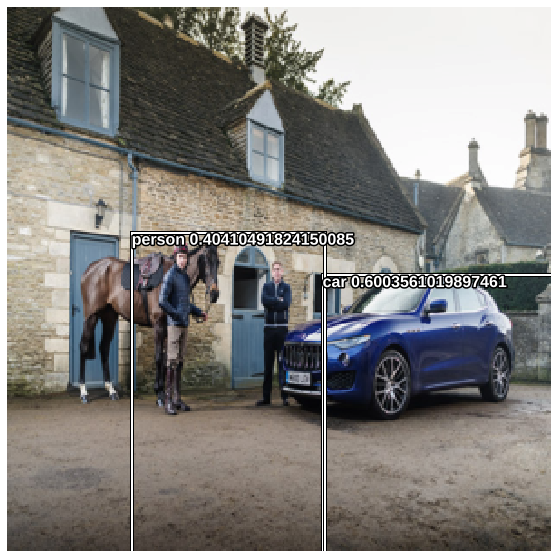

In [36]:
with torch.no_grad():
  model=main(epochs=0)
  !wget https://keyassets.timeincuk.net/inspirewp/live/wp-content/uploads/sites/14/2017/04/Maserati-Car-vs-Horse_1.jpg -O image.jpg
  image = Image.open("image.jpg")
  new_image = FT.resize(image,(300, 300))

  # Convert PIL image to Torch tensor
  new_image = FT.to_tensor(new_image)

  # Normalize by mean and standard deviation of ImageNet data that our base VGG was trained on
  new_image = FT.normalize(new_image, mean=trainLoader.dataset.mean, std=trainLoader.dataset.std)
  new_image = new_image.unsqueeze(0)
  new_image = new_image.to(device)
  predicted_locs , predicted_scores = model(new_image)
  det_boxes, det_labels, det_scores = detect_objects(predicted_locs, predicted_scores ,  priors_cxcy = model.priors_cxcy,min_score=0.4)
  i , b , l ,s = new_image, det_boxes[0].to("cpu"), det_labels[0].to("cpu"), det_scores[0].to("cpu")
  i = i.clone().detach().to("cpu").data
  if len(i.shape)==4 : i = i.squeeze(0)
  i = i.permute(1,2,0) 
  i = i.mul_(trainLoader.dataset.std).add_(trainLoader.dataset.mean)
  i = torch.clamp(i,0,1)
  f, ax1 = plt.subplots(1, 1,figsize=(15,10))   
  ax1.imshow(i)
  ax1.grid(False)
  ax1.set_xticks([])
  ax1.set_yticks([])

  for box ,label,score in zip(b , l,s):
    box = box * torch.FloatTensor([300]*4)
    print(VOCDataset.class_names[label])
    draw_rect(ax1,box )
    draw_text(ax1, box[:2], trainLoader.dataset.class_names[label]+" "+str(score.item()), sz=16)

In [0]:
f.savefig("Objectdetect.jpg")

In [0]:
!cp Objectdetect.jpg /gdrive/My\ Drive/

In [0]:

true_difficulties=[torch.ones(2510,device=device)]
true_difficulties = torch.cat(true_difficulties, dim=0)
true_difficulties

In [0]:
[torch.rand([2,3])]

In [0]:
torch.cat([torch.rand([2,3])],dim=0)

In [0]:
voc_labels = ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
              'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')
label_map = {k: v + 1 for v, k in enumerate(voc_labels)}
label_map['background'] = 0
rev_label_map = {v: k for k, v in label_map.items()}
len(label_map)

In [0]:
def calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels):
    """
    Calculate the Mean Average Precision (mAP) of detected objects.
    See https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173 for an explanation
    :param det_boxes: list of tensors, one tensor for each image containing detected objects' bounding boxes
    :param det_labels: list of tensors, one tensor for each image containing detected objects' labels
    :param det_scores: list of tensors, one tensor for each image containing detected objects' labels' scores
    :param true_boxes: list of tensors, one tensor for each image containing actual objects' bounding boxes
    :param true_labels: list of tensors, one tensor for each image containing actual objects' labels
    :param true_difficulties: list of tensors, one tensor for each image containing actual objects' difficulty (0 or 1)
    :return: list of average precisions for all classes, mean average precision (mAP)
    """
    assert len(det_boxes) == len(det_labels) == len(det_scores) == len(true_boxes) == len(
        true_labels)
    #== len(
     #   true_difficulties)  # these are all lists of tensors of the same length, i.e. number of images
    n_classes = 21

    # Store all (true) objects in a single continuous tensor while keeping track of the image it is from
    true_images = list()
    for i in range(len(true_labels)):
        true_images.extend([i] * true_labels[i].size(0))
        #print("Number of true images",len(true_images))
        #print("true_images",true_images)
    true_images = torch.LongTensor(true_images).to(
        device)  # (n_objects), n_objects is the total no. of objects across all images
    true_boxes = torch.cat(true_boxes, dim=0)  # (n_objects, 4)
    true_labels = torch.cat(true_labels, dim=0)  # (n_objects)
    #print("True lables",true_labels)
    #print("True lables",true_labels.shape)
    #print("True boxes",true_boxes)
    #print(" Shape of True boxes",true_boxes.shape)
    true_difficulties=[torch.zeros(true_labels.shape,device=device)]
    true_difficulties = torch.cat(true_difficulties, dim=0)  # (n_objects)
    #print("true_difficulties",true_difficulties)
    #print("Shape of true_difficulties",true_difficulties.shape)
    assert true_images.size(0) == true_boxes.size(0) == true_labels.size(0)

    # Store all detections in a single continuous tensor while keeping track of the image it is from
    det_images = list()
    for i in range(len(det_labels)):
        det_images.extend([i] * det_labels[i].size(0))
    det_images = torch.LongTensor(det_images).to(device)  # (n_detections)
    det_boxes = torch.cat(det_boxes, dim=0)  # (n_detections, 4)
    #print("det_boxes",det_boxes)
    #print("No of objects detected(det_boxes)",det_boxes.shape)
    det_labels = torch.cat(det_labels, dim=0)  # (n_detections)
    #print("det_labels",det_labels)
    #print("det_labels_subset",det_labels[det_labels==1])
    #print("det_labels",det_labels.shape)
    det_scores = torch.cat(det_scores, dim=0)  # (n_detections)
    #print("det_scores",det_scores)
    #print("det_scores",det_scores.shape)

    assert det_images.size(0) == det_boxes.size(0) == det_labels.size(0) == det_scores.size(0)

    # Calculate APs for each class (except background)
    average_precisions = torch.zeros((n_classes - 1), dtype=torch.float)  # (n_classes - 1)
    for c in range(1, n_classes):
        # Extract only objects with this class
        true_class_images = true_images[true_labels == c]  # (n_class_objects)
        #print("true_class_images----",true_class_images)
        true_class_boxes = true_boxes[true_labels == c]  # (n_class_objects, 4)
        true_class_difficulties = true_difficulties[true_labels == c]  # (n_class_objects)
        #print("True Class boxes shape of  class :{} ,{}".format(c,true_class_boxes.shape[0]))
        #print("True Class difficulties",true_class_difficulties)
        n_easy_class_objects = (1 - true_class_difficulties).sum().item()  # ignore difficult objects
        #print("n_easy_class",n_easy_class_objects)
        # Keep track of which true objects with this class have already been 'detected'
        # So far, none
        true_class_boxes_detected = torch.zeros((true_class_difficulties.size(0)), dtype=torch.uint8).to(
            device)  # (n_class_objects)

        # Extract only detections with this class
        det_class_images = det_images[det_labels == c]  # (n_class_detections)
        det_class_boxes = det_boxes[det_labels == c]  # (n_class_detections, 4)
        det_class_scores = det_scores[det_labels == c]  # (n_class_detections)
        #print("det_class_score",det_class_scores)
        #print("No of detected objects of class {} is {}(det_class_score)".format(c,det_class_scores.shape[0]))
        n_class_detections = det_class_boxes.size(0)
        #print("n_class_detections",n_class_detections)
        if n_class_detections == 0:
            continue

        # Sort detections in decreasing order of confidence/scores
        det_class_scores, sort_ind = torch.sort(det_class_scores, dim=0, descending=True)  # (n_class_detections)
        det_class_images = det_class_images[sort_ind]  # (n_class_detections)
        #print("det_class_images",det_class_images)
        #print("det_class_images",det_class_images.shape)
        det_class_boxes = det_class_boxes[sort_ind]  # (n_class_detections, 4)

        # In the order of decreasing scores, check if true or false positive
        true_positives = torch.zeros((n_class_detections), dtype=torch.float).to(device)  # (n_class_detections)
        false_positives = torch.zeros((n_class_detections), dtype=torch.float).to(device)  # (n_class_detections)
        for d in range(n_class_detections):
            this_detection_box = det_class_boxes[d].unsqueeze(0)  # (1, 4)
            this_image = det_class_images[d]  # (), scalar
            #print("this_image",this_image.shape)

            # Find objects in the same image with this class, their difficulties, and whether they have been detected before
            object_boxes = true_class_boxes[true_class_images == this_image]  # (n_class_objects_in_img)
            object_difficulties = true_class_difficulties[true_class_images == this_image]  # (n_class_objects_in_img)
            # If no such object in this image, then the detection is a false positive
            if object_boxes.size(0) == 0:
                false_positives[d] = 1
                continue

            # Find maximum overlap of this detection with objects in this image of this class
            overlaps = find_jaccard_overlap(this_detection_box, object_boxes)  # (1, n_class_objects_in_img)
            max_overlap, ind = torch.max(overlaps.squeeze(0), dim=0)  # (), () - scalars

            # 'ind' is the index of the object in these image-level tensors 'object_boxes', 'object_difficulties'
            # In the original class-level tensors 'true_class_boxes', etc., 'ind' corresponds to object with index...
            original_ind = torch.LongTensor(range(true_class_boxes.size(0)))[true_class_images == this_image][ind]
            # We need 'original_ind' to update 'true_class_boxes_detected'

            # If the maximum overlap is greater than the threshold of 0.5, it's a match
            if max_overlap.item() > 0.5:
                # If the object it matched with is 'difficult', ignore it
                if object_difficulties[ind] == 0:
                    # If this object has already not been detected, it's a true positive
                    if true_class_boxes_detected[original_ind] == 0:
                        true_positives[d] = 1
                        true_class_boxes_detected[original_ind] = 1  # this object has now been detected/accounted for
                    # Otherwise, it's a false positive (since this object is already accounted for)
                    else:
                        false_positives[d] = 1
            # Otherwise, the detection occurs in a different location than the actual object, and is a false positive
            else:
                false_positives[d] = 1

        # Compute cumulative precision and recall at each detection in the order of decreasing scores
        cumul_true_positives = torch.cumsum(true_positives, dim=0)  # (n_class_detections)
        cumul_false_positives = torch.cumsum(false_positives, dim=0)  # (n_class_detections)
        cumul_precision = cumul_true_positives / (
                cumul_true_positives + cumul_false_positives + 1e-10)  # (n_class_detections)
        cumul_recall = cumul_true_positives / n_easy_class_objects  # (n_class_detections)

        # Find the mean of the maximum of the precisions corresponding to recalls above the threshold 't'
        recall_thresholds = torch.arange(start=0, end=1.1, step=.1).tolist()  # (11)
        precisions = torch.zeros((len(recall_thresholds)), dtype=torch.float).to(device)  # (11)
        for i, t in enumerate(recall_thresholds):
            recalls_above_t = cumul_recall >= t
            if recalls_above_t.any():
                precisions[i] = cumul_precision[recalls_above_t].max()
            else:
                precisions[i] = 0.
        average_precisions[c - 1] = precisions.mean()  # c is in [1, n_classes - 1]

    # Calculate Mean Average Precision (mAP)
    mean_average_precision = average_precisions.mean().item()

    # Keep class-wise average precisions in a dictionary
    average_precisions = {rev_label_map[c + 1]: v for c, v in enumerate(average_precisions.tolist())}

    return average_precisions, mean_average_precision

In [0]:
def calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels):
    """
    Calculate the Mean Average Precision (mAP) of detected objects.
    See https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173 for an explanation
    :param det_boxes: list of tensors, one tensor for each image containing detected objects' bounding boxes
    :param det_labels: list of tensors, one tensor for each image containing detected objects' labels
    :param det_scores: list of tensors, one tensor for each image containing detected objects' labels' scores
    :param true_boxes: list of tensors, one tensor for each image containing actual objects' bounding boxes
    :param true_labels: list of tensors, one tensor for each image containing actual objects' labels
    :param true_difficulties: list of tensors, one tensor for each image containing actual objects' difficulty (0 or 1)
    :return: list of average precisions for all classes, mean average precision (mAP)
    """
    assert len(det_boxes) == len(det_labels) == len(det_scores) == len(true_boxes) == len(
        true_labels)
    #== len(
     #   true_difficulties)  # these are all lists of tensors of the same length, i.e. number of images
    n_classes = 21

    # Store all (true) objects in a single continuous tensor while keeping track of the image it is from
    true_images = list()
    for i in range(len(true_labels)):
        true_images.extend([i] * true_labels[i].size(0))
        #print("Number of true images",len(true_images))
        #print("true_images",true_images)
    true_images = torch.LongTensor(true_images).to(
        device)  # (n_objects), n_objects is the total no. of objects across all images
    true_boxes = torch.cat(true_boxes, dim=0)  # (n_objects, 4)
    true_labels = torch.cat(true_labels, dim=0)  # (n_objects)
    #print("True lables",true_labels)
    #print("True lables",true_labels.shape)
    #print("True boxes",true_boxes)
    #print(" Shape of True boxes",true_boxes.shape)
    true_difficulties=[torch.zeros(true_labels.shape,device=device)]
    true_difficulties = torch.cat(true_difficulties, dim=0)  # (n_objects)
    #print("true_difficulties",true_difficulties)
    #print("Shape of true_difficulties",true_difficulties.shape)
    assert true_images.size(0) == true_boxes.size(0) == true_labels.size(0)

    # Store all detections in a single continuous tensor while keeping track of the image it is from
    det_images = list()
    for i in range(len(det_labels)):
        det_images.extend([i] * det_labels[i].size(0))
    det_images = torch.LongTensor(det_images).to(device)  # (n_detections)
    det_boxes = torch.cat(det_boxes, dim=0)  # (n_detections, 4)
    #print("det_boxes",det_boxes)
    #print("No of objects detected(det_boxes)",det_boxes.shape)
    det_labels = torch.cat(det_labels, dim=0)  # (n_detections)
    #print("det_labels",det_labels)
    #print("det_labels_subset",det_labels[det_labels==1])
    #print("det_labels",det_labels.shape)
    det_scores = torch.cat(det_scores, dim=0)  # (n_detections)
    #print("det_scores",det_scores)
    #print("det_scores",det_scores.shape)

    assert det_images.size(0) == det_boxes.size(0) == det_labels.size(0) == det_scores.size(0)

    # Calculate APs for each class (except background)
    average_precisions = torch.zeros((n_classes - 1), dtype=torch.float)  # (n_classes - 1)
    for c in range(1, n_classes):
        # Extract only objects with this class
        true_class_images = true_images[true_labels == c]  # (n_class_objects)
        #print("true_class_images----",true_class_images)
        true_class_boxes = true_boxes[true_labels == c]  # (n_class_objects, 4)
        true_class_difficulties = true_difficulties[true_labels == c]  # (n_class_objects)
        #print("True Class boxes shape of  class :{} ,{}".format(c,true_class_boxes.shape[0]))
        #print("True Class difficulties",true_class_difficulties)
        n_easy_class_objects = (1 - true_class_difficulties).sum().item()  # ignore difficult objects
        #print("n_easy_class",n_easy_class_objects)
        # Keep track of which true objects with this class have already been 'detected'
        # So far, none
        true_class_boxes_detected = torch.zeros((true_class_difficulties.size(0)), dtype=torch.uint8).to(
            device)  # (n_class_objects)

        # Extract only detections with this class
        det_class_images = det_images[det_labels == c]  # (n_class_detections)
        det_class_boxes = det_boxes[det_labels == c]  # (n_class_detections, 4)
        det_class_scores = det_scores[det_labels == c]  # (n_class_detections)
        #print("det_class_score",det_class_scores)
        #print("No of detected objects of class {} is {}(det_class_score)".format(c,det_class_scores.shape[0]))
        n_class_detections = det_class_boxes.size(0)
        #print("n_class_detections",n_class_detections)
        if n_class_detections == 0:
            continue

        # Sort detections in decreasing order of confidence/scores
        det_class_scores, sort_ind = torch.sort(det_class_scores, dim=0, descending=True)  # (n_class_detections)
        det_class_images = det_class_images[sort_ind]  # (n_class_detections)
        #print("det_class_images",det_class_images)
        #print("det_class_images",det_class_images.shape)
        #det_class_boxes = det_class_boxes[sort_ind]  # (n_class_detections, 4)

        # In the order of decreasing scores, check if true or false positive
        true_positives = torch.zeros((n_class_detections), dtype=torch.float).to(device)  # (n_class_detections)
        false_positives = torch.zeros((n_class_detections), dtype=torch.float).to(device)  # (n_class_detections)
        for d in range(n_class_detections):
            this_detection_box = det_class_boxes[d].unsqueeze(0)  # (1, 4)
            this_image = det_class_images[d]  # (), scalar
            #print("this_image",this_image.shape)

            # Find objects in the same image with this class, their difficulties, and whether they have been detected before
            object_boxes = true_class_boxes[true_class_images == this_image]  # (n_class_objects_in_img)
            object_difficulties = true_class_difficulties[true_class_images == this_image]  # (n_class_objects_in_img)
            # If no such object in this image, then the detection is a false positive
            if object_boxes.size(0) == 0:
                false_positives[d] = 1
                continue

            # Find maximum overlap of this detection with objects in this image of this class
            overlaps = find_jaccard_overlap(this_detection_box, object_boxes)  # (1, n_class_objects_in_img)
            max_overlap, ind = torch.max(overlaps.squeeze(0), dim=0)  # (), () - scalars

            # 'ind' is the index of the object in these image-level tensors 'object_boxes', 'object_difficulties'
            # In the original class-level tensors 'true_class_boxes', etc., 'ind' corresponds to object with index...
            original_ind = torch.LongTensor(range(true_class_boxes.size(0)))[true_class_images == this_image][ind]
            # We need 'original_ind' to update 'true_class_boxes_detected'

            # If the maximum overlap is greater than the threshold of 0.5, it's a match
            if max_overlap.item() > 0.5:
                # If the object it matched with is 'difficult', ignore it
                if object_difficulties[ind] == 0:
                    # If this object has already not been detected, it's a true positive
                    if true_class_boxes_detected[original_ind] == 0:
                        true_positives[d] = 1
                        true_class_boxes_detected[original_ind] = 1  # this object has now been detected/accounted for
                    # Otherwise, it's a false positive (since this object is already accounted for)
                    else:
                        false_positives[d] = 1
            # Otherwise, the detection occurs in a different location than the actual object, and is a false positive
            else:
                false_positives[d] = 1

        # Compute cumulative precision and recall at each detection in the order of decreasing scores
        cumul_true_positives = torch.cumsum(true_positives, dim=0)  # (n_class_detections)
        cumul_false_positives = torch.cumsum(false_positives, dim=0)  # (n_class_detections)
        cumul_precision = cumul_true_positives / (
                cumul_true_positives + cumul_false_positives + 1e-10)  # (n_class_detections)
        cumul_recall = cumul_true_positives / n_easy_class_objects  # (n_class_detections)

        # Find the mean of the maximum of the precisions corresponding to recalls above the threshold 't'
        recall_thresholds = torch.arange(start=0, end=1.1, step=.1).tolist()  # (11)
        precisions = torch.zeros((len(recall_thresholds)), dtype=torch.float).to(device)  # (11)
        for i, t in enumerate(recall_thresholds):
            recalls_above_t = cumul_recall >= t
            if recalls_above_t.any():
                precisions[i] = cumul_precision[recalls_above_t].max()
            else:
                precisions[i] = 0.
        average_precisions[c - 1] = precisions.mean()  # c is in [1, n_classes - 1]

    # Calculate Mean Average Precision (mAP)
    mean_average_precision = average_precisions.mean().item()

    # Keep class-wise average precisions in a dictionary
    average_precisions = {rev_label_map[c + 1]: v for c, v in enumerate(average_precisions.tolist())}

    return average_precisions, mean_average_precision

In [0]:
def evaluate(test_loader, model):
    """
    Evaluate.
    :param test_loader: DataLoader for test data
    :param model: model
    """

    # Make sure it's in eval mode
    model.eval()

    # Lists to store detected and true boxes, labels, scores
    det_boxes = list()
    det_labels = list()
    det_scores = list()
    true_boxes = list()
    true_labels = list()
    #true_difficulties = list()  # it is necessary to know which objects are 'difficult', see 'calculate_mAP' in utils.py

    with torch.no_grad():
        # Batches
        for i, (images, boxes, labels) in enumerate(tqdm(test_loader, desc='Evaluating')):
            images = images.to(device)  # (N, 3, 300, 300)

            # Forward prop.
            predicted_locs, predicted_scores = model(images)

            # Detect objects in SSD output
            det_boxes_batch, det_labels_batch, det_scores_batch = model.detect_objects(predicted_locs, predicted_scores,
                                                                                       min_score=0.01, max_overlap=0.45,
                                                                                       top_k=200)
            # Evaluation MUST be at min_score=0.01, max_overlap=0.45, top_k=200 for fair comparision with the paper's results and other repos

            # Store this batch's results for mAP calculation
            boxes = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]
            #difficulties = [d.to(device) for d in difficulties]

            det_boxes.extend(det_boxes_batch)
            det_labels.extend(det_labels_batch)
            det_scores.extend(det_scores_batch)
            true_boxes.extend(boxes)
            true_labels.extend(labels)
            #true_difficulties.extend(difficulties)

        # Calculate mAP
        APs, mAP = calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels)

    # Print AP for each class
    print(APs)

    print('\nMean Average Precision (mAP): %.3f' % mAP)

In [0]:
model=main(epochs=0)
model.eval()
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False,
                                          collate_fn=valset.collate_fn, num_workers=0, pin_memory=True)
evaluate(val_loader, model)

In [0]:
def evaluate(test_loader, model):
    """
    Evaluate.
    :param test_loader: DataLoader for test data
    :param model: model
    """

    # Make sure it's in eval mode
    model.eval()

    # Lists to store detected and true boxes, labels, scores
    det_boxes = list()
    det_labels = list()
    det_scores = list()
    true_boxes = list()
    true_labels = list()
    #true_difficulties = list()  # it is necessary to know which objects are 'difficult', see 'calculate_mAP' in utils.py

    with torch.no_grad():
      
        # Batches

      images, boxes, labels =next(iter(test_loader))

      images = images.to(device)  # (N, 3, 300, 300)

      # Forward prop.
      predicted_locs, predicted_scores = model(images)

      # Detect objects in SSD output
      det_boxes_batch, det_labels_batch, det_scores_batch = model.detect_objects(predicted_locs, predicted_scores,
                                                                                 min_score=0.1, max_overlap=0.45,
                                                                                 top_k=200)
      # Evaluation MUST be at min_score=0.01, max_overlap=0.45, top_k=200 for fair comparision with the paper's results and other repos

      # Store this batch's results for mAP calculation
      boxes = [b.to(device) for b in boxes]
      labels = [l.to(device) for l in labels]
      #difficulties = [d.to(device) for d in difficulties]

      det_boxes.extend(det_boxes_batch)
      det_labels.extend(det_labels_batch)
      det_scores.extend(det_scores_batch)
      true_boxes.extend(boxes)
      true_labels.extend(labels)
      #true_difficulties.extend(difficulties)
      return det_boxes,det_labels,det_scores,true_boxes,true_labels

In [0]:
model=main(epochs=0)
model.eval()
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False,
                                          collate_fn=valset.collate_fn, num_workers=0, pin_memory=True)
det_boxes,det_labels,det_scores,true_boxes,true_labels=evaluate(val_loader, model)

In [0]:
true_labels

In [0]:
det_labels

In [0]:
calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels)